In [1]:
import pandas as pd
import numpy as np


# The above is to merge datasets and the following deals with NA values

In [2]:
final_research = pd.read_csv('../Data/complete_footfall_research.csv')

In [3]:
final_research['timestamp'] = pd.to_datetime(final_research['timestamp'])

final_research['year'] = final_research['timestamp'].dt.year
final_research['month'] = final_research['timestamp'].dt.month
final_research['day'] = final_research['timestamp'].dt.day
final_research['hour'] = final_research['timestamp'].dt.hour
final_research['dayofweek'] = final_research['timestamp'].dt.dayofweek
final_research['minute'] = final_research['timestamp'].dt.minute

In [4]:
pip install holidays

Note: you may need to restart the kernel to use updated packages.


In [5]:
import holidays

uk_holidays = holidays.UK()

final_research['is_holiday'] = final_research['timestamp'].apply(lambda x: x in uk_holidays)

In [6]:
# count the number of days after the original date
final_research['after_day'] = (final_research['timestamp'] - final_research['timestamp'].min()).dt.days + 1

In [7]:
final_research = final_research.sort_values('timestamp')

In [8]:
final_research['is_sales'] = False

def get_summer_sale(year):
    return pd.Timestamp(year=year, month=6, day=15), pd.Timestamp(year=year, month=7, day=31)

def get_christmas_sale(year):
    current_year_sale = (pd.Timestamp(year=year, month=12, day=26), pd.Timestamp(year=year+1, month=1, day=10))
    previous_year_sale = (pd.Timestamp(year=year-1, month=12, day=26), pd.Timestamp(year=year, month=1, day=10))
    return current_year_sale, previous_year_sale

years = final_research['timestamp'].dt.year.unique()

for year in years:
    start_date, end_date = get_summer_sale(year)
    final_research.loc[(final_research['timestamp'] >= start_date) & (final_research['timestamp'] <= end_date), 'is_sales'] = True
    
    current_year_sale, previous_year_sale = get_christmas_sale(year)
    start_date, end_date = current_year_sale
    final_research.loc[(final_research['timestamp'] >= start_date) & (final_research['timestamp'] <= end_date), 'is_sales'] = True
    start_date, end_date = previous_year_sale
    final_research.loc[(final_research['timestamp'] >= start_date) & (final_research['timestamp'] <= end_date), 'is_sales'] = True

def get_black_friday(year):
    nov1 = pd.Timestamp(year=year, month=11, day=1)
    day_of_week = nov1.dayofweek
    first_friday = 7 - day_of_week if day_of_week <= 4 else 14 - day_of_week
    black_friday = nov1 + pd.Timedelta(days=first_friday + 21)
    return black_friday

for year in years:
    black_friday = get_black_friday(year)
    final_research.loc[final_research['timestamp'].dt.date == black_friday.date(), 'is_sales'] = True


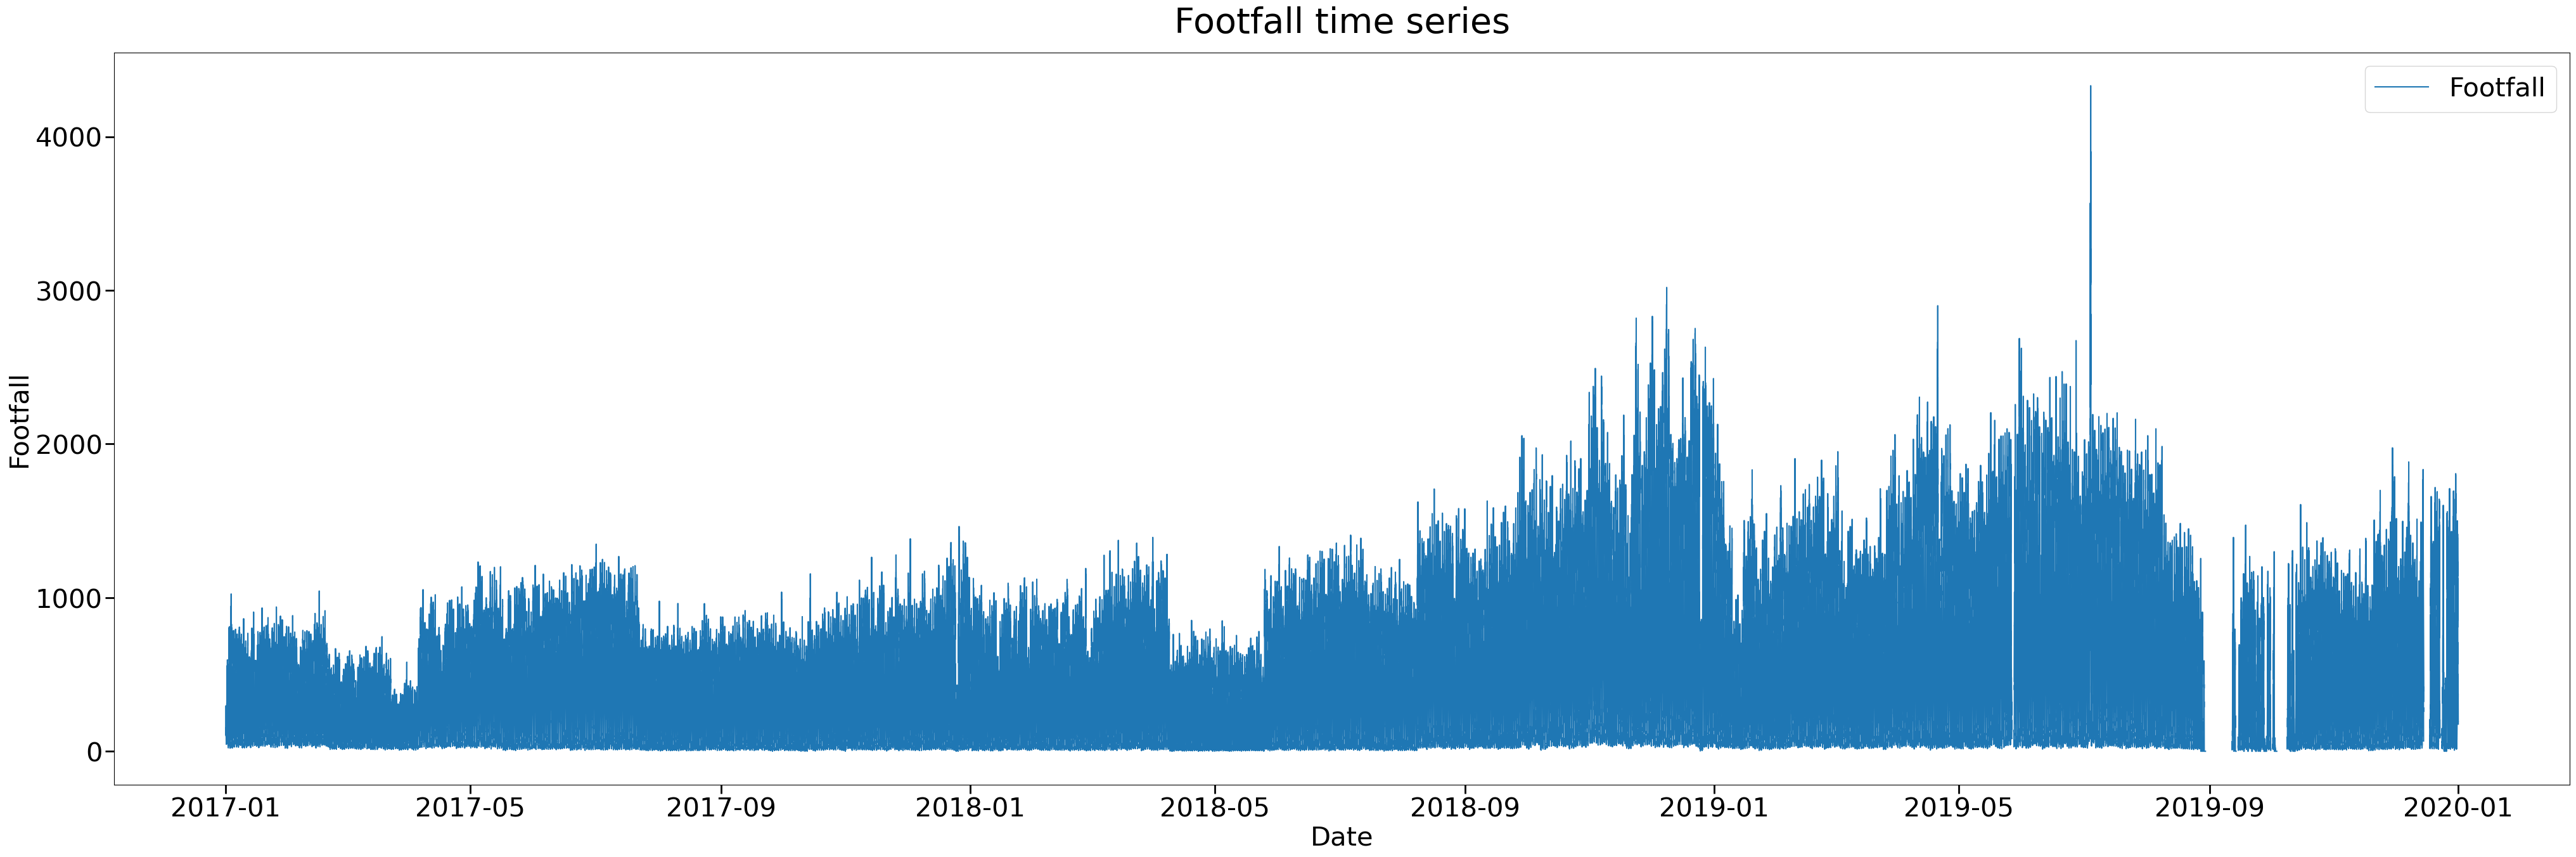

In [9]:
import matplotlib.pyplot as plt

plot_footfall = final_research.copy()

plot_footfall.set_index('timestamp', inplace=True)

# Plot the time series
plt.figure(figsize=(50, 15))
plt.plot(plot_footfall.index, plot_footfall['footfall'], label='Footfall')
plt.xlabel('Date', fontsize=30)
plt.tick_params(axis='both', which='both', direction='out', length=10, width=2)
plt.ylabel('Footfall', fontsize=30)
plt.title('Footfall time series', fontsize = 40, y = 1.02)
plt.legend()
plt.grid(False)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=30)
# Save the plot
#plt.savefig('../final_graph/footfall_time_series.png')
plt.show()

In [10]:
# split the data set chronologically, 80%train，20%test
train_size = int(len(final_research) * 0.8)
train_data = final_research.iloc[:train_size]
test_data = final_research.iloc[train_size:]

features = ['timestamp', 'temp', 'dwpt', 'rhum', 'wspd', 'pres', 'Entry', 'Exit', 'rainfall',
            'year', 'month', 'day', 'hour', 'minute', 'dayofweek', 'is_holiday', 'after_day', 'is_sales']
X_train = train_data[features]
y_train = train_data[['timestamp', 'footfall']]
X_test = test_data[features]
y_test = test_data[['timestamp', 'footfall']]


In [11]:
print("X_train NA values:\n", X_train.isna().sum())
print("X_test NA values:\n", X_test.isna().sum())
print("y_train NA values:\n", y_train.isna().sum())
print("y_test NA values:\n", y_test.isna().sum())

X_train NA values:
 timestamp      0
temp           0
dwpt           0
rhum           0
wspd          72
pres           0
Entry          0
Exit           0
rainfall      48
year           0
month          0
day            0
hour           0
minute         0
dayofweek      0
is_holiday     0
after_day      0
is_sales       0
dtype: int64
X_test NA values:
 timestamp     0
temp          0
dwpt          0
rhum          0
wspd          0
pres          0
Entry         0
Exit          0
rainfall      0
year          0
month         0
day           0
hour          0
minute        0
dayofweek     0
is_holiday    0
after_day     0
is_sales      0
dtype: int64
y_train NA values:
 timestamp    0
footfall     0
dtype: int64
y_test NA values:
 timestamp       0
footfall     7200
dtype: int64


In [12]:
def fill_footfall(y, timestamps):
    df = pd.DataFrame({'footfall': y, 'timestamp': timestamps}).copy()

    df['footfall_filled'] = df['footfall']
    
    # 1. use the average 30 minutes before and after the day to fill in NA
    df['footfall_filled'] = df['footfall_filled'].combine_first(
        df['footfall'].rolling(window=13, min_periods=1, center=True).mean())
    
    # 2. fill in NA using the mean of the same time period for the preceding and following weeks
    for idx in df[df['footfall_filled'].isna()].index:
        timestamp = df.loc[idx, 'timestamp']
        week_1 = timestamp - pd.DateOffset(weeks=1)
        week_2 = timestamp + pd.DateOffset(weeks=1)
        
        # Mask for exactly the same time in the previous and next week
        mask_1 = (df['timestamp'] == week_1)
        mask_2 = (df['timestamp'] == week_2)
        
        mean_value = df.loc[mask_1 | mask_2, 'footfall_filled'].mean()
        
        if pd.notna(mean_value):
            df.loc[idx, 'footfall_filled'] = mean_value
            
    return df[['timestamp', 'footfall_filled']]


In [13]:
# fill NA of weather
def fill_predictors(df, columns):
    df = df.copy()
    
    for column in columns:
        # First fill with the mean of the surrounding 13 windows 
        df[column] = df[column].fillna(df[column].rolling(window=13, min_periods=1, center=True).mean())
        
        # Then fill remaining NaNs with the mean of the surrounding 25 windows 
        df[column] = df[column].fillna(df[column].rolling(window=25, min_periods=1, center=True).mean())
        
        # Optionally, fill remaining NaNs with the mean of the surrounding 50 windows
        df[column] = df[column].fillna(df[column].rolling(window=37, min_periods=1, center=True).mean())
    
    return df

In [14]:
X_train_filled = fill_predictors(X_train, features[1:]) 
X_test_filled = fill_predictors(X_test, features[1:])   

y_train_filled = fill_footfall(y_train['footfall'], y_train['timestamp'])
y_test_filled = fill_footfall(y_test['footfall'], y_test['timestamp'])

In [15]:
# add the mean of the previous day's footfall as a new predictor

X_train_filled['footfall_previous'] = y_train_filled['footfall_filled'].shift(12)
X_test_filled['footfall_previous'] = y_test_filled['footfall_filled'].shift(12)

In [16]:
print(X_train_filled.shape)
print(X_test_filled.shape)
print(y_train_filled.shape)
print(y_test_filled.shape)

(252288, 19)
(63072, 19)
(252288, 2)
(63072, 2)


# After the na values are filled above, EDA is started by merging the dataset

In [17]:
train_data_merged = X_train_filled.copy()
train_data_merged['footfall'] = y_train_filled['footfall_filled'].values

test_data_merged = X_test_filled.copy()
test_data_merged['footfall'] = y_test_filled['footfall_filled'].values

final_data = pd.concat([train_data_merged, test_data_merged], axis=0).sort_values(by='timestamp')


In [18]:
final_data.head()

timestamp  temp  dwpt  rhum  wspd    pres  Entry  Exit  rainfall  \
0 2017-01-01 00:00:00   6.7   5.2    90  18.4  1024.1   49.0  93.0       0.0   
1 2017-01-01 00:05:00   6.7   5.2    90  18.4  1024.1   49.0  93.0       0.0   
2 2017-01-01 00:10:00   6.7   5.2    90  18.4  1024.1   49.0  93.0       0.0   
3 2017-01-01 00:15:00   6.7   5.2    90  18.4  1024.1   15.0  22.0       0.0   
4 2017-01-01 00:20:00   6.7   5.2    90  18.4  1024.1   15.0  22.0       0.0   

   year  month  day  hour  minute  dayofweek  is_holiday  after_day  is_sales  \
0  2017      1    1     0       0          6        True          1      True   
1  2017      1    1     0       5          6        True          1      True   
2  2017      1    1     0      10          6        True          1      True   
3  2017      1    1     0      15          6        True          1      True   
4  2017      1    1     0      20          6        True          1      True   

   footfall_previous  footfall  
0                NaN     152.0  
1                NaN     131.0  
2                NaN     135.0  
3                NaN     135.0  
4                NaN     108.0

/tmp/ipykernel_4039/2040826670.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_research_2019['timestamp'] = pd.to_datetime(final_research_2019['timestamp'])
/tmp/ipykernel_4039/2040826670.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data_2019['timestamp'] = pd.to_datetime(final_data_2019['timestamp'])


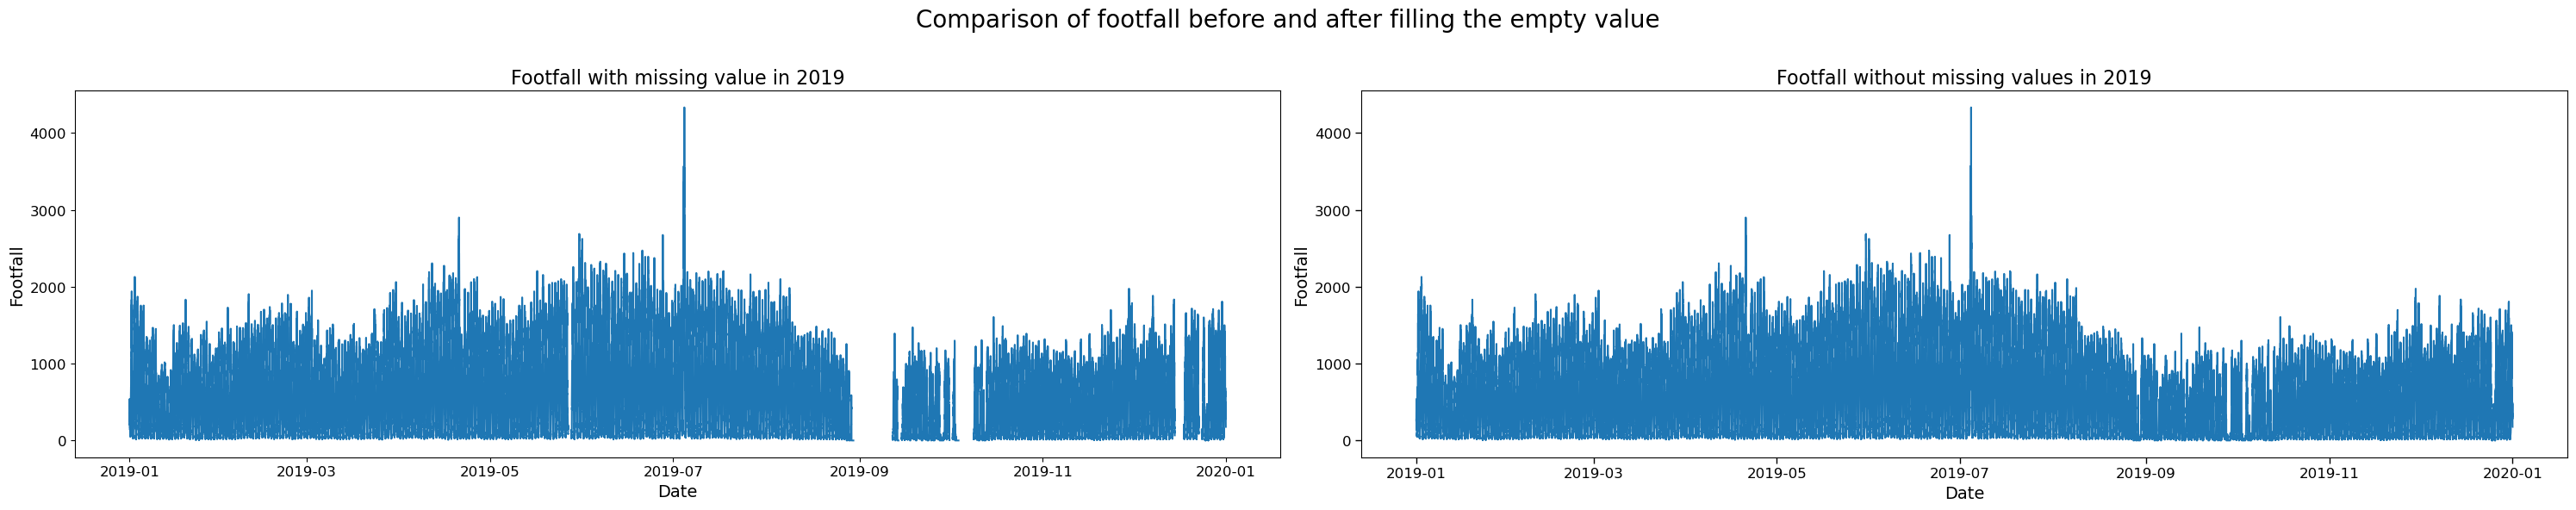

In [19]:
# Filter data for the year 2019
final_research_2019 = final_research[(final_research['timestamp'] >= '2019-01-01') & (final_research['timestamp'] < '2020-01-01')]
final_data_2019 = final_data[(final_data['timestamp'] >= '2019-01-01') & (final_data['timestamp'] < '2020-01-01')]

# Convert 'timestamp' to datetime for final_research
final_research_2019['timestamp'] = pd.to_datetime(final_research_2019['timestamp'])
final_data_2019['timestamp'] = pd.to_datetime(final_data_2019['timestamp'])
# Set 'timestamp' as the index for final_research
final_research_2019.set_index('timestamp', inplace=True)
final_data_2019.set_index('timestamp', inplace=True)
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(30, 6))

# Plot the time series for final_research_2019
axes[0].plot(final_research_2019.index, final_research_2019['footfall'])
axes[0].set_title('Footfall with missing value in 2019', fontsize=16)
axes[0].set_xlabel('Date', fontsize=14)
axes[0].set_ylabel('Footfall', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)
plt.suptitle('Comparison of footfall before and after filling the empty value', fontsize=20)
plt.tick_params(axis='both', which='both', direction='out', length=5, width=1)
axes[0].grid(False)

# Plot the time series for final_data_2019
axes[1].plot(final_data_2019.index, final_data_2019['footfall'])
axes[1].set_title('Footfall without missing values in 2019', fontsize=16)
axes[1].set_xlabel('Date', fontsize=14)
axes[1].set_ylabel('Footfall', fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12)
plt.suptitle('Comparison of footfall before and after filling the empty value', fontsize=20)
plt.tick_params(axis='both', which='both', direction='out', length=5, width=1)
axes[1].grid(False)

# Adjust layout and save the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
#plt.savefig('../final_graph/footfall_time_series_comparison.png')
plt.show()


### time features

In [20]:
dayofweek_map = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

final_data['dayofweek'] = final_data['dayofweek'].map(dayofweek_map)

def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

final_data['season'] = final_data['month'].apply(get_season)

def match_day(row):
    if row['dayofweek'] in ['Monday', 'Tuesday', 'Wednesday', 'Thursday']:
            return 'MTT'
    elif row['dayofweek'] == 'Friday':
            return 'FRI'
    elif row['dayofweek'] == 'Saturday':
            return 'SAT'
    else:
            return 'SUN'

final_data['sub'] = final_data.apply(match_day, axis=1)

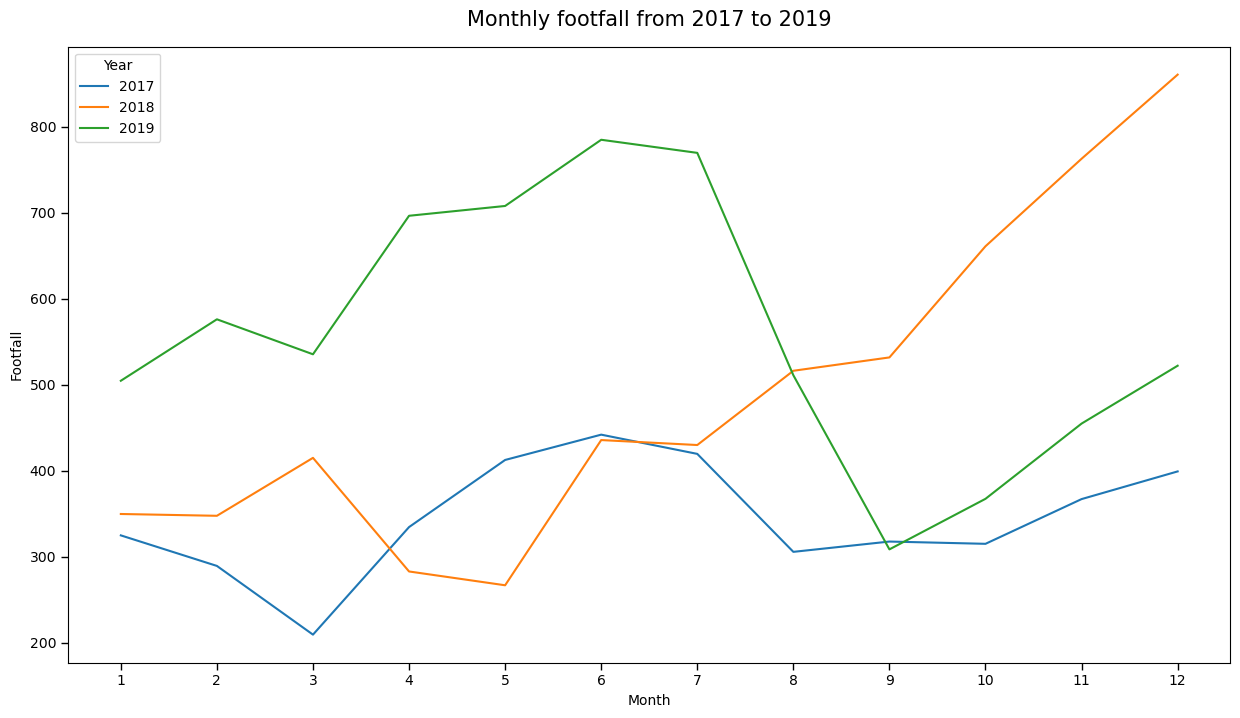

In [21]:
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(15, 8))

for year in final_data['year'].unique():
    yearly_data = final_data[final_data['year'] == year]
    monthly_avg = yearly_data.groupby('month')['footfall'].mean()
    plt.plot(monthly_avg.index, monthly_avg.values, label=year)

plt.title('Monthly footfall from 2017 to 2019', fontsize=15, y=1.02)
plt.xlabel('Month')
plt.ylabel('Footfall')
plt.tick_params(axis='both', which='both', direction='out', length=5, width=1)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=15
                                             ))
plt.legend(title='Year')
#plt.savefig('../final_graph/monthly_footfall.png')
plt.grid(False)
plt.show()

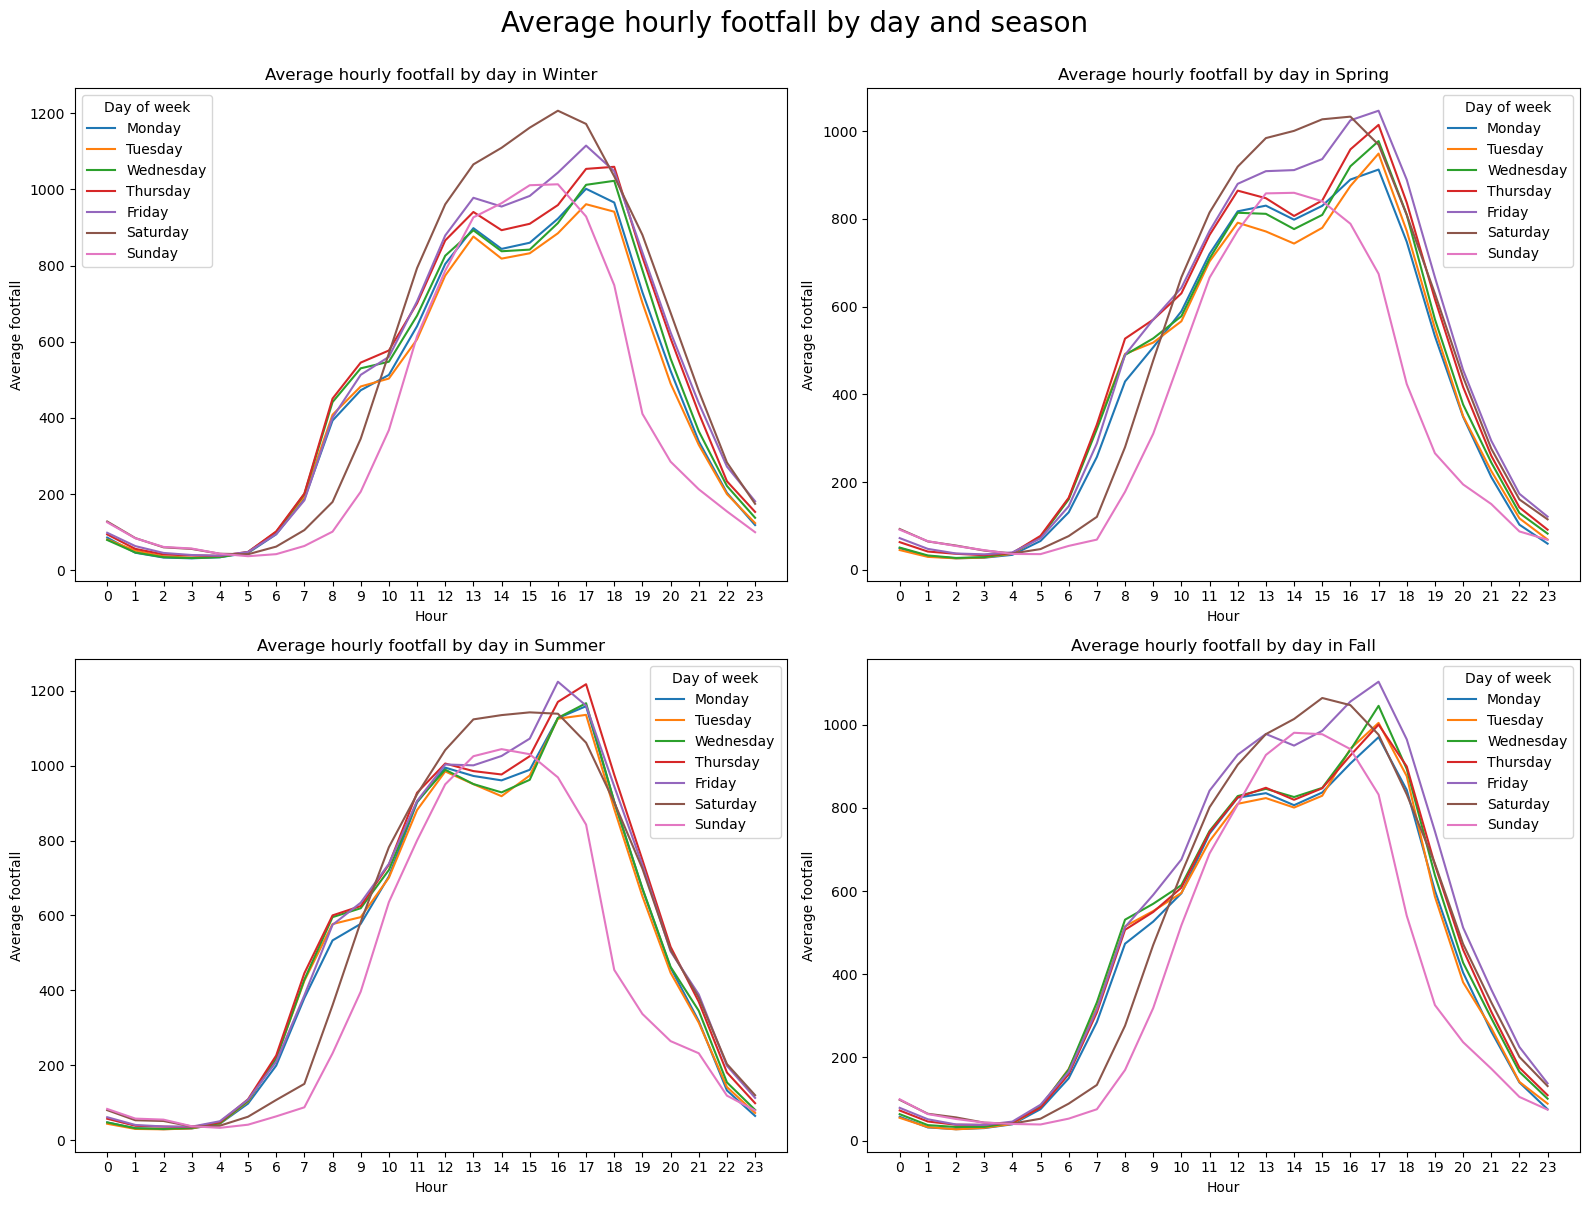

In [22]:
grouped = final_data.groupby(['season', 'dayofweek', 'hour']).agg({'footfall': 'mean'}).reset_index()

seasons = final_data['season'].unique()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
axs = axs.flatten()

for i, season in enumerate(seasons):
    for j, day in enumerate(days):
        subset = grouped[(grouped['season'] == season) & (grouped['dayofweek'] == day)]
        axs[i].plot(subset['hour'], subset['footfall'], label=day, color=colors[j])
    
    axs[i].set_title(f'Average hourly footfall by day in {season}')
    axs[i].set_xlabel('Hour')
    axs[i].set_ylabel('Average footfall')
    axs[i].legend(title='Day of week')
    axs[i].set_xticks(range(0, 24, 1))  
plt.suptitle('Average hourly footfall by day and season', fontsize=20, y=1)
plt.tight_layout()
#plt.savefig('../final_graph/existing_footfall_hourly.png')
plt.show()

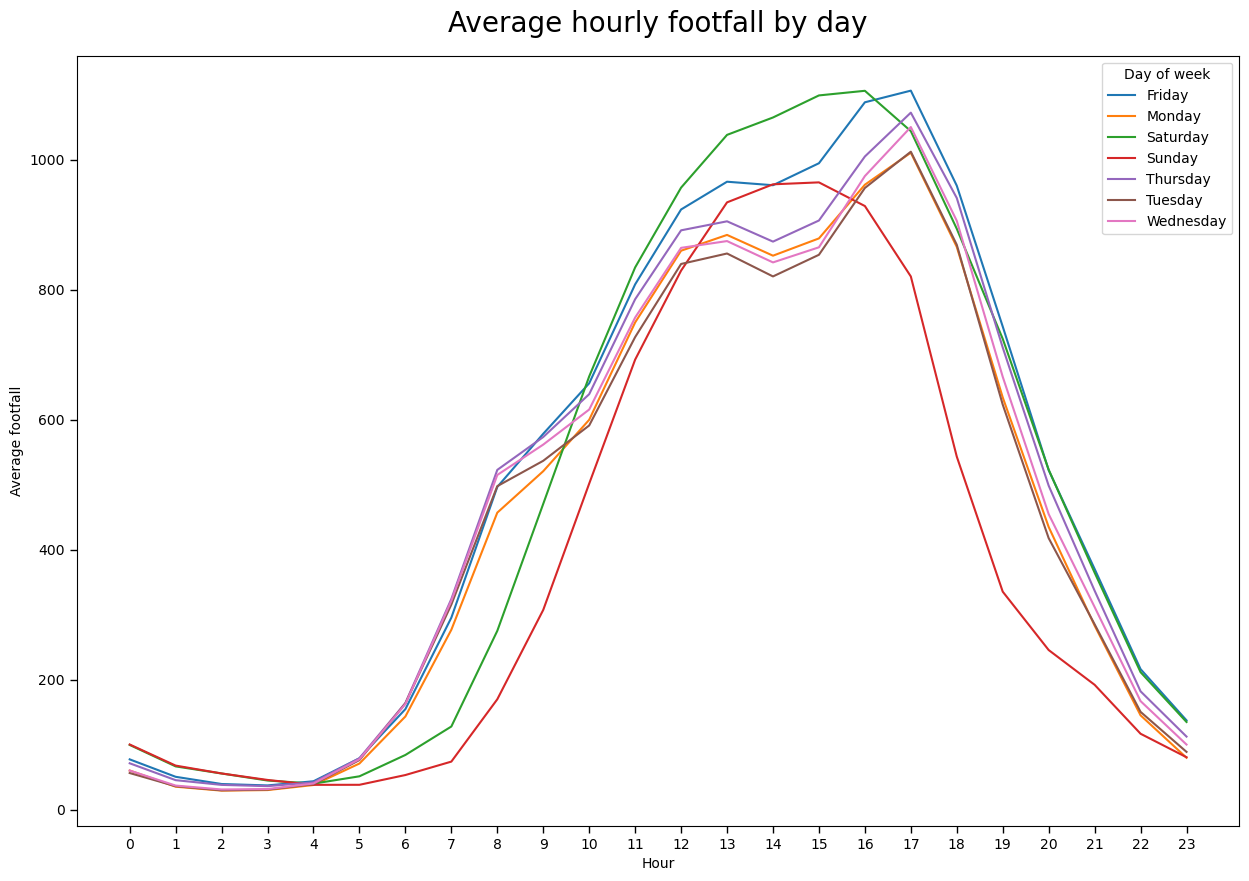

In [23]:
hourly_avg = final_data.groupby(['dayofweek', 'hour'])['footfall'].mean().unstack(level=0)

hourly_avg.plot(figsize=(15, 10))
plt.title('Average hourly footfall by day', fontsize=20, y=1.02)
plt.xlabel('Hour')
plt.ylabel('Average footfall')
plt.legend(title='Day of week')
plt.tick_params(axis='both', which='both', direction='out', length=5, width=1)
plt.grid(False)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=15
                                             ))  
plt.xticks(range(0, 24, 1))
#plt.savefig('../final_graph/hourly_footfall.png')
plt.show()

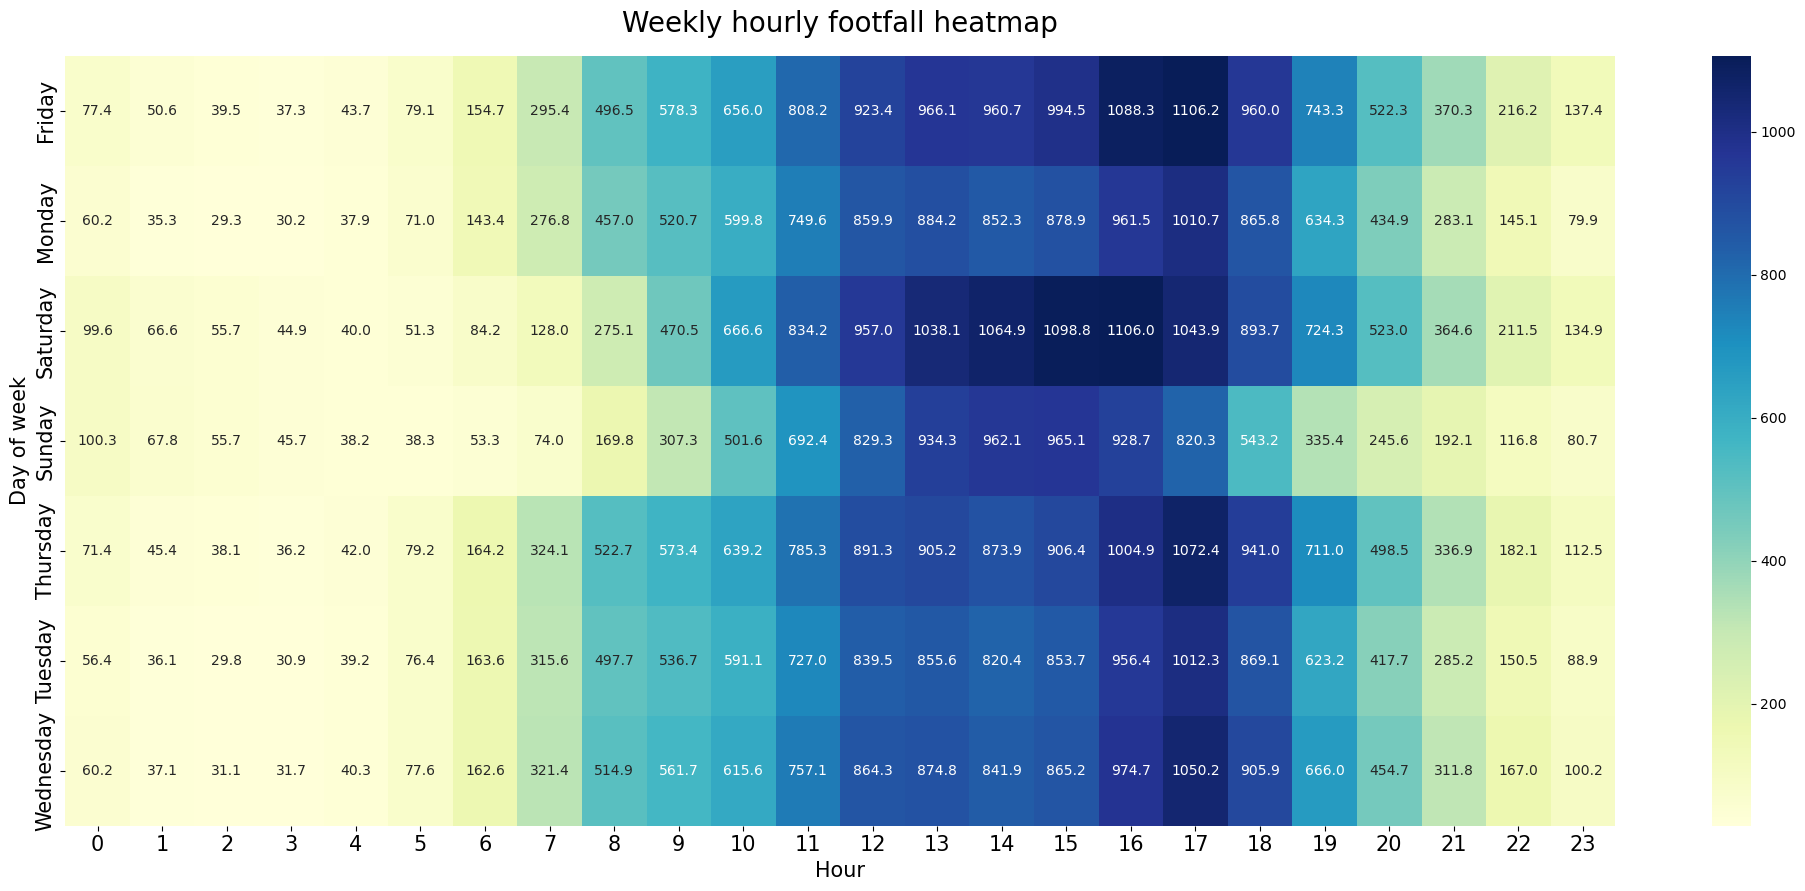

In [24]:
import seaborn as sns

hourly_avg = final_data.groupby(['dayofweek', 'hour'])['footfall'].mean().unstack()

plt.figure(figsize=(25, 10))
sns.heatmap(hourly_avg, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title('Weekly hourly footfall heatmap', fontsize=20, y=1.02)
plt.xlabel('Hour', fontsize=15)
plt.ylabel('Day of week', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.savefig('../final_graph/weekly_hourly_heatmap.png')
plt.show()

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

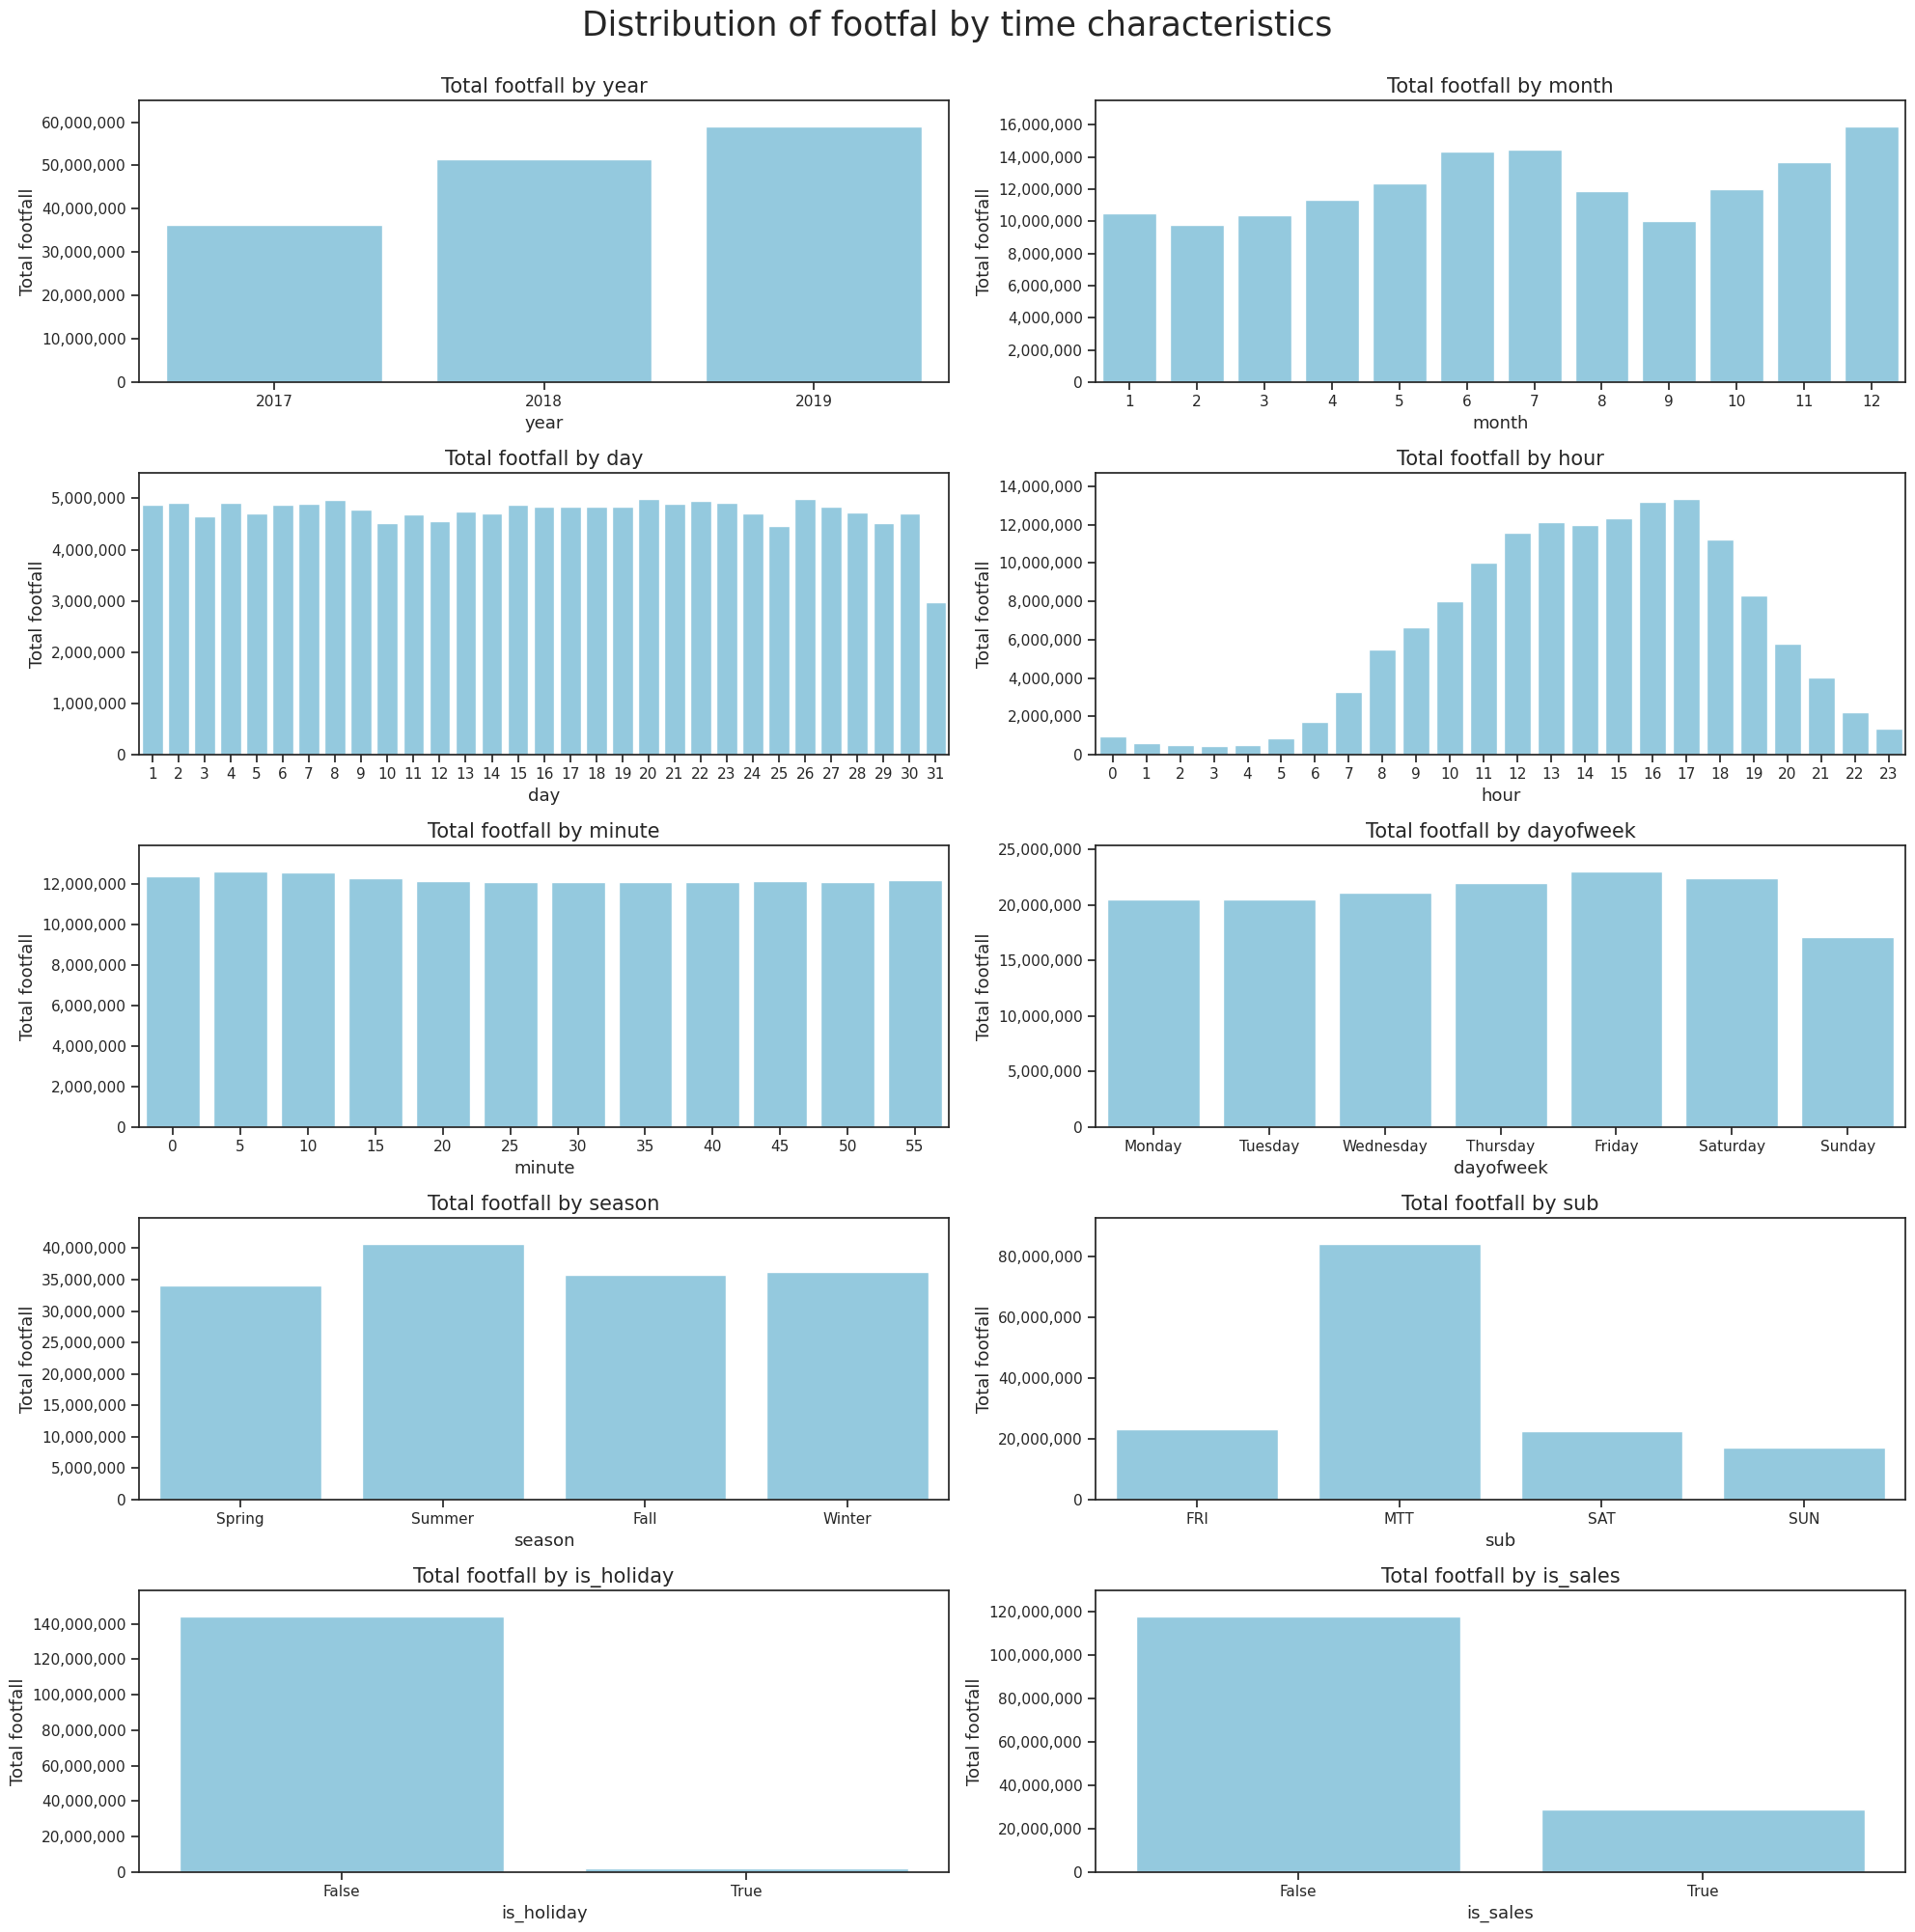

In [25]:
sns.set(style="ticks")

time_feature = ['year', 'month', 'day', 'hour', 'minute', 'dayofweek', 'season', 'sub', 'is_holiday',  'is_sales']

dayofweek_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
final_data['dayofweek'] = pd.Categorical(final_data['dayofweek'], categories=dayofweek_order, ordered=True)
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
final_data['season'] = pd.Categorical(final_data['season'], categories=season_order, ordered=True)


plt.figure(figsize=(20, 20))
for i, feature in enumerate(time_feature, 1):
    plt.subplot(5, 2, i)
    df_grouped = final_data.groupby(feature)['footfall'].sum().reset_index()
    sns.barplot(x=feature, y='footfall', data=df_grouped, color='#87CEEB')
    plt.title(f'Total footfall by {feature}', fontsize=15)
    plt.xlabel(feature, fontsize=13)
    plt.ylabel('Total footfall', fontsize=13)
    plt.ylim(0, df_grouped['footfall'].max() * 1.1)
    ax = plt.gca()
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
plt.suptitle('Distribution of footfal by time characteristics', fontsize=25, y=1)
plt.tight_layout()
#plt.savefig("../final_graph/total_footfall_by_time_features.png")

plt.show()

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

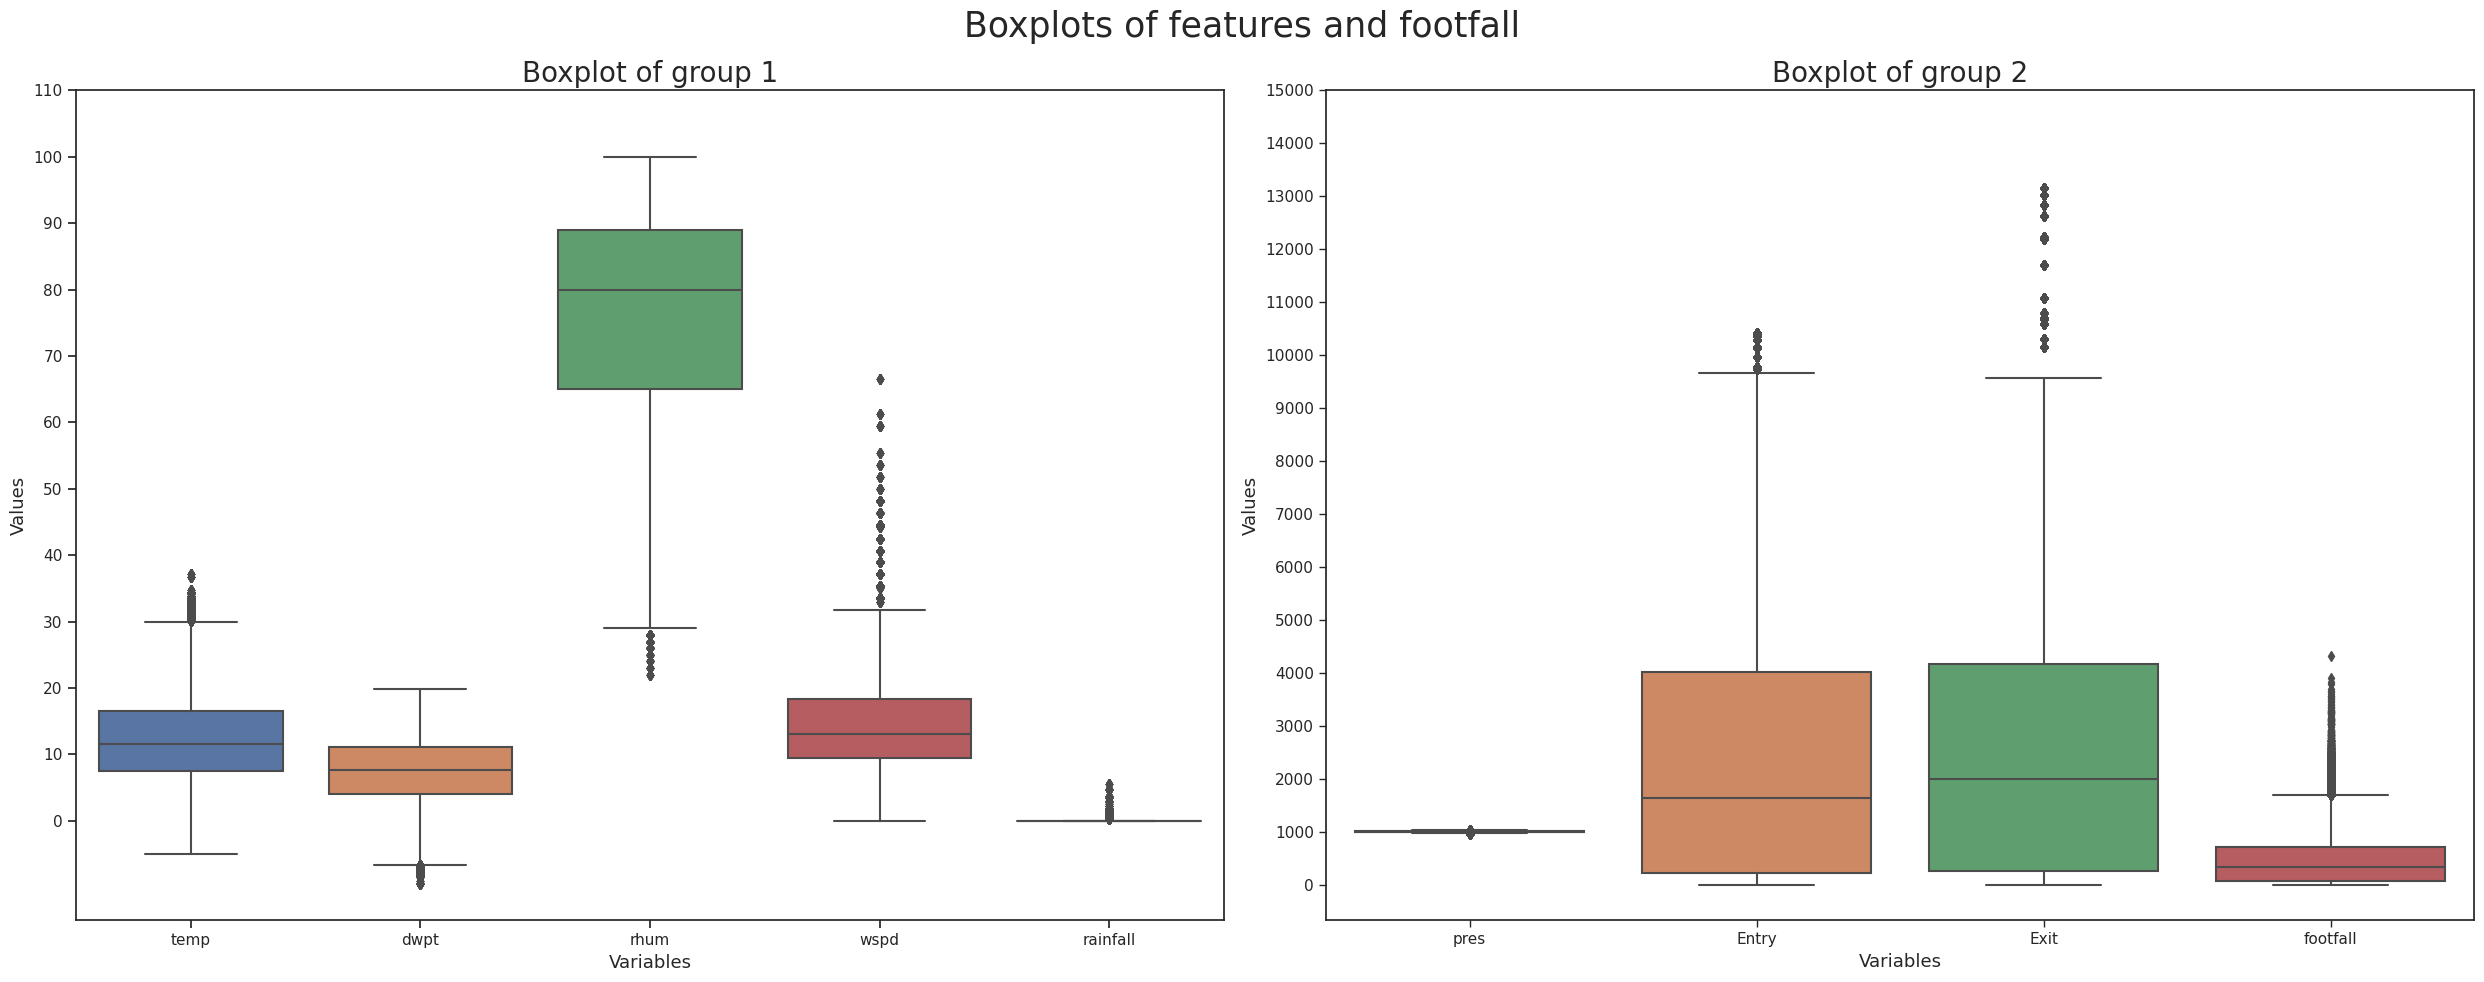

In [26]:
group1 = ['temp', 'dwpt', 'rhum', 'wspd', 'rainfall']
group2 = ['pres', 'Entry', 'Exit', 'footfall']

fig, axes = plt.subplots(1, 2, figsize=(25, 10))

sns.boxplot(data=final_data[group1], ax=axes[0])
axes[0].set_title('Boxplot of group 1', fontsize=20)
axes[0].set_xlabel('Variables', fontsize=13)
axes[0].set_ylabel('Values', fontsize=13)
axes[0].set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]) 

sns.boxplot(data=final_data[group2], ax=axes[1])
axes[1].set_title('Boxplot of group 2', fontsize=20)
axes[1].set_xlabel('Variables', fontsize=13)
axes[1].set_ylabel('Values', fontsize=13)
axes[1].set_yticks([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000])  
axes[1].tick_params(axis='both', which='both', direction='out', length=5, width=1)

plt.tick_params(axis='both', which='both', direction='out', length=5, width=1)
plt.suptitle('Boxplots of features and footfall', fontsize=25)
plt.tight_layout()

#plt.savefig('../final_graph/features_boxplot_grouped.png')
plt.show()


/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

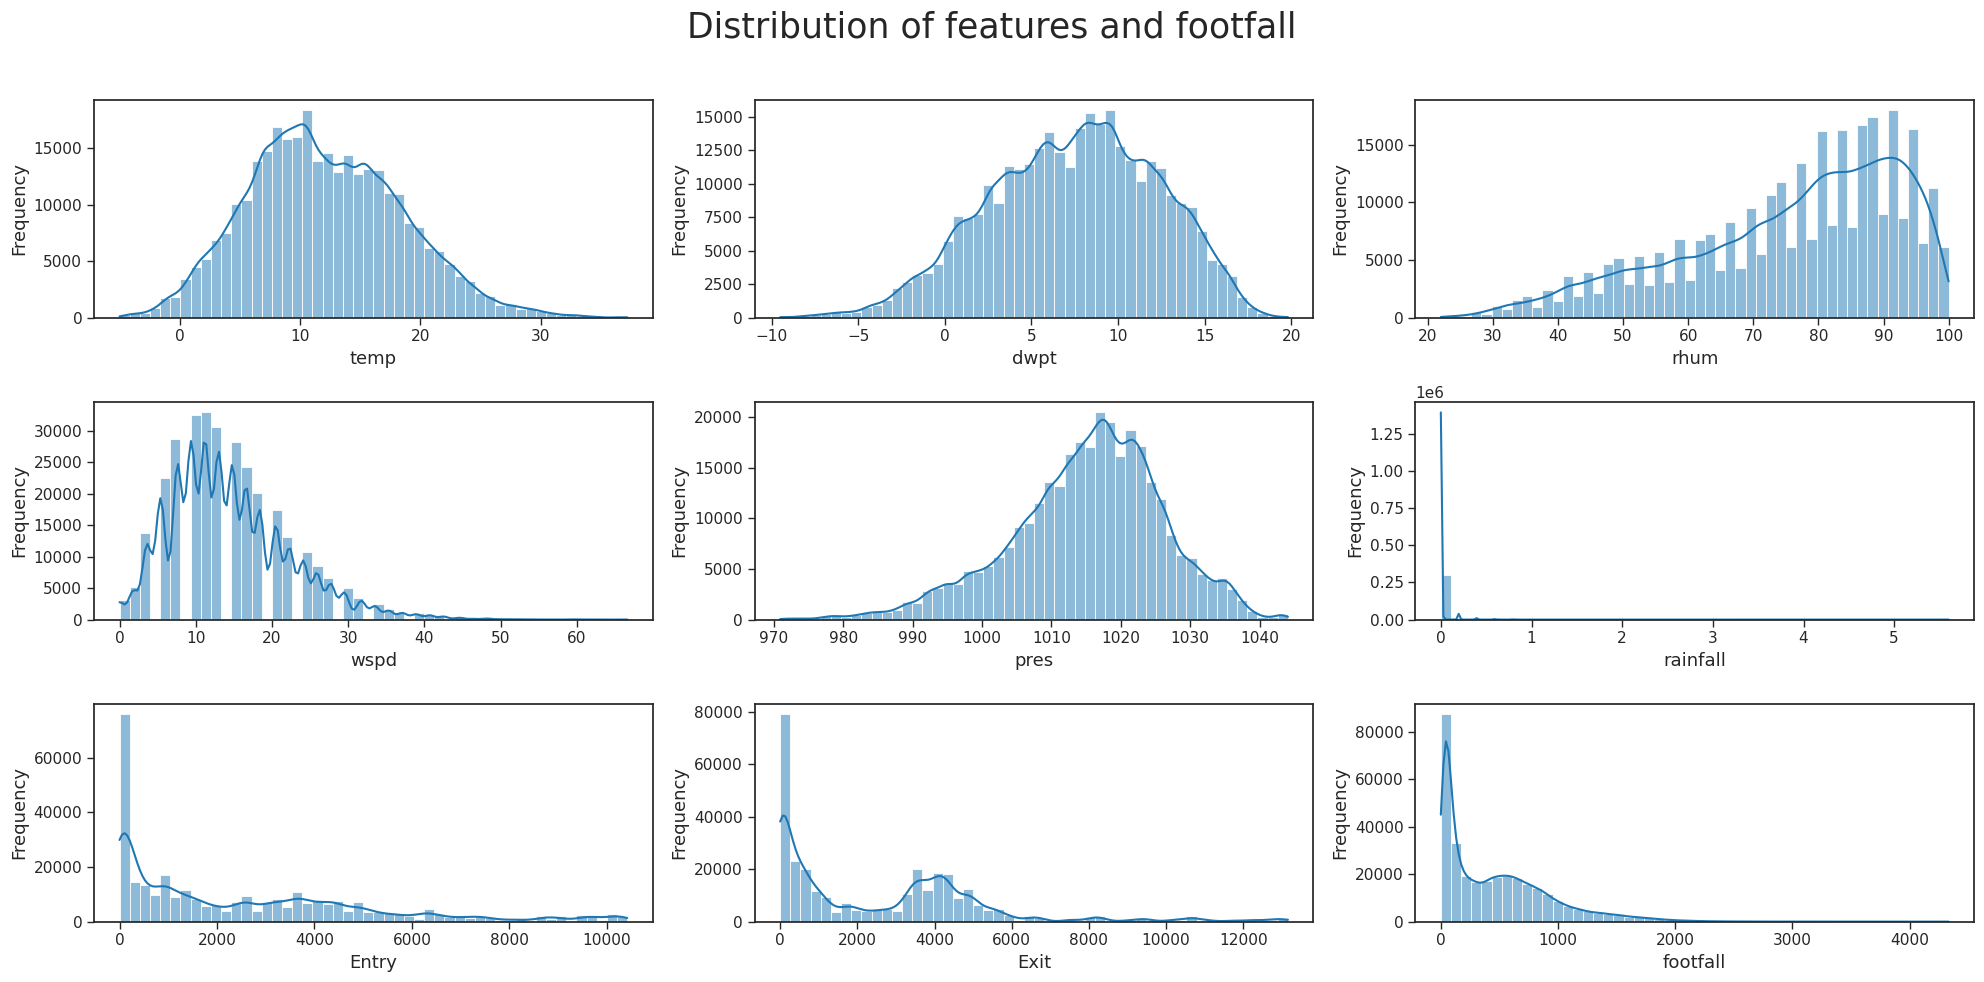

In [27]:
useful_features = ['temp', 'dwpt', 'rhum', 'wspd', 'pres', 'rainfall', 'Entry', 'Exit', 'footfall']

plt.figure(figsize=(20, 10))

for i, feature in enumerate(useful_features):
    ax = plt.subplot(3, 3, i + 1) 
    sns.histplot(final_data[feature], bins=50, kde=True, ax=ax, color='#1f77b4')
    ax.set_xlabel(feature, fontsize=13)
    ax.set_ylabel('Frequency', fontsize=13)
    ax.tick_params(axis='both', which='both', direction='out', length=5, width=1)
plt.suptitle('Distribution of features and footfall', fontsize=25)
plt.tight_layout(rect=[0, 0, 1, 0.96])  
#plt.savefig('../final_graph/distribution_histograms_new.png')
plt.show()



<Figure size 2000x1000 with 0 Axes>

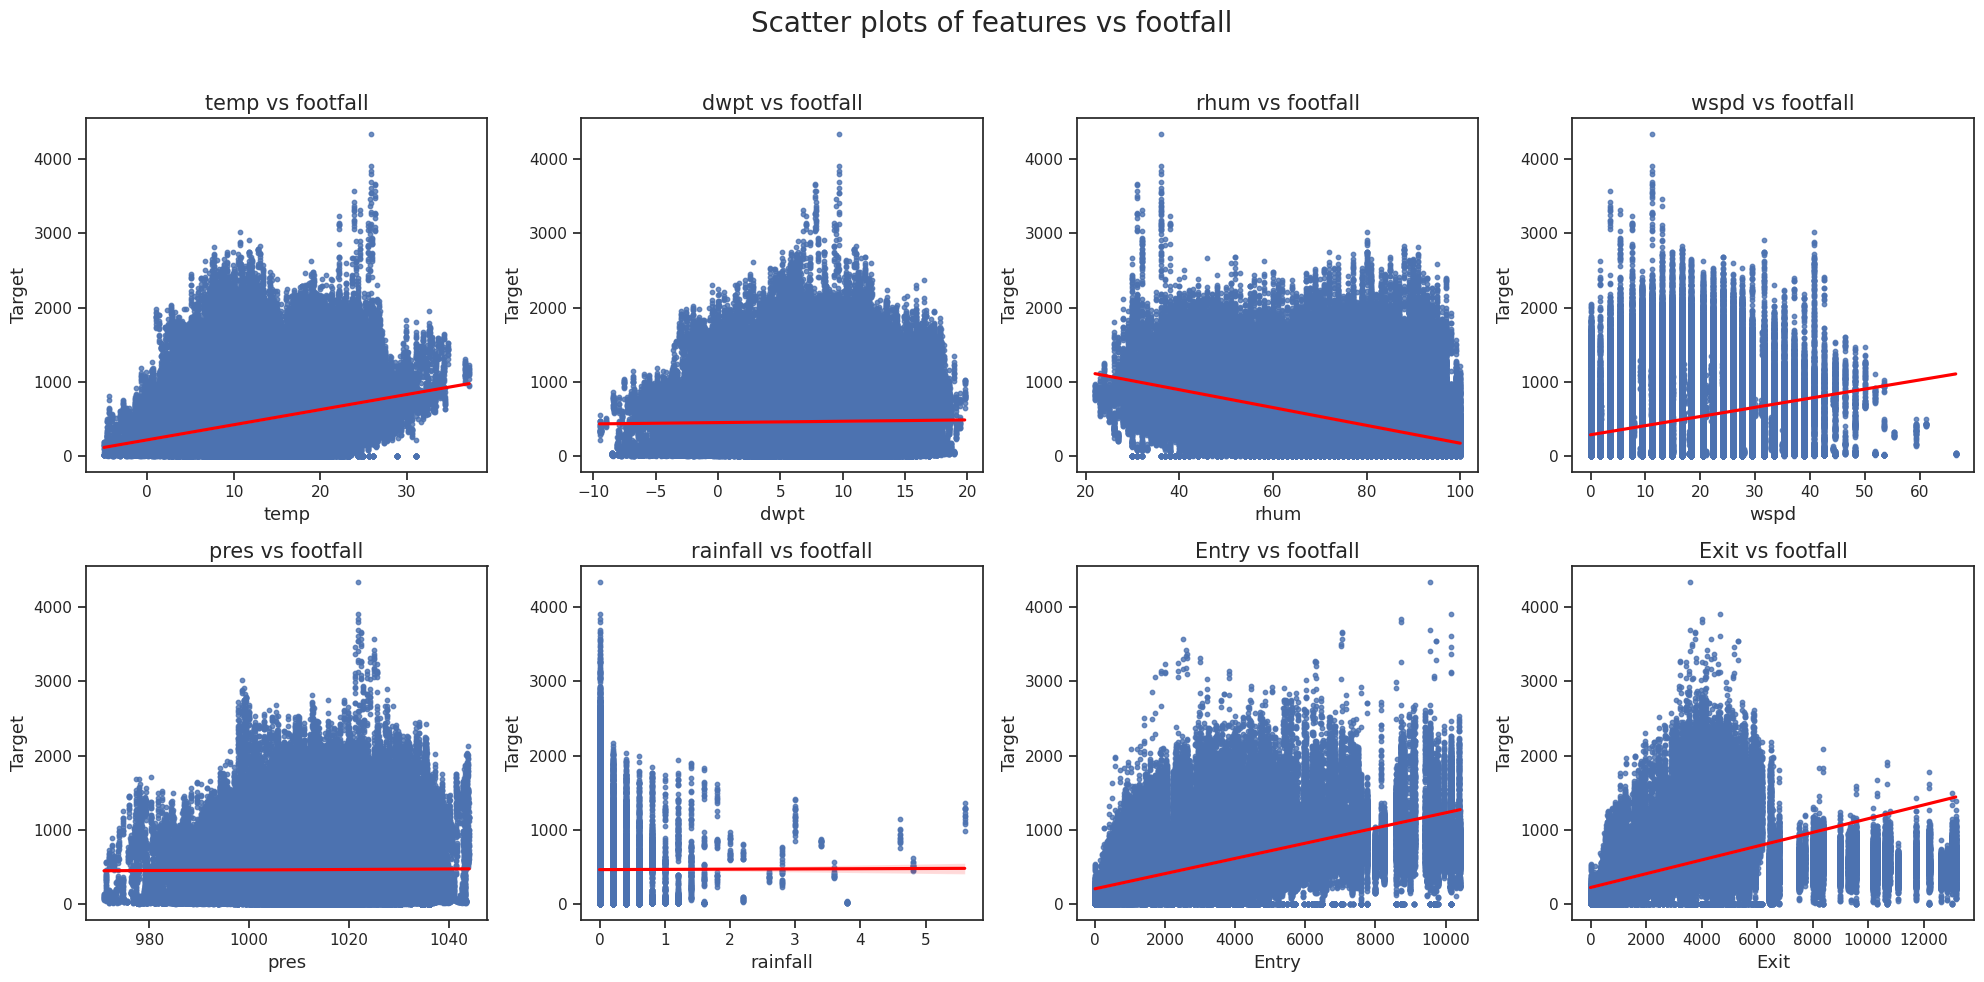

In [28]:
plt.figure(figsize=(20, 10))
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, feature in enumerate(useful_features[:-1]):
    row, col = divmod(i, 4)
    sns.regplot(ax=axes[row, col], x=final_data[feature], y=final_data['footfall'], scatter_kws={'s': 10}, line_kws={"color": "red"})
    axes[row, col].set_title(f'{feature} vs footfall', fontsize=15)
    axes[row, col].set_xlabel(feature, fontsize=13)
    axes[row, col].set_ylabel('Target', fontsize=13)
plt.suptitle('Scatter plots of features vs footfall', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
#plt.savefig('../final_graph/scatterplots.png')
plt.show()


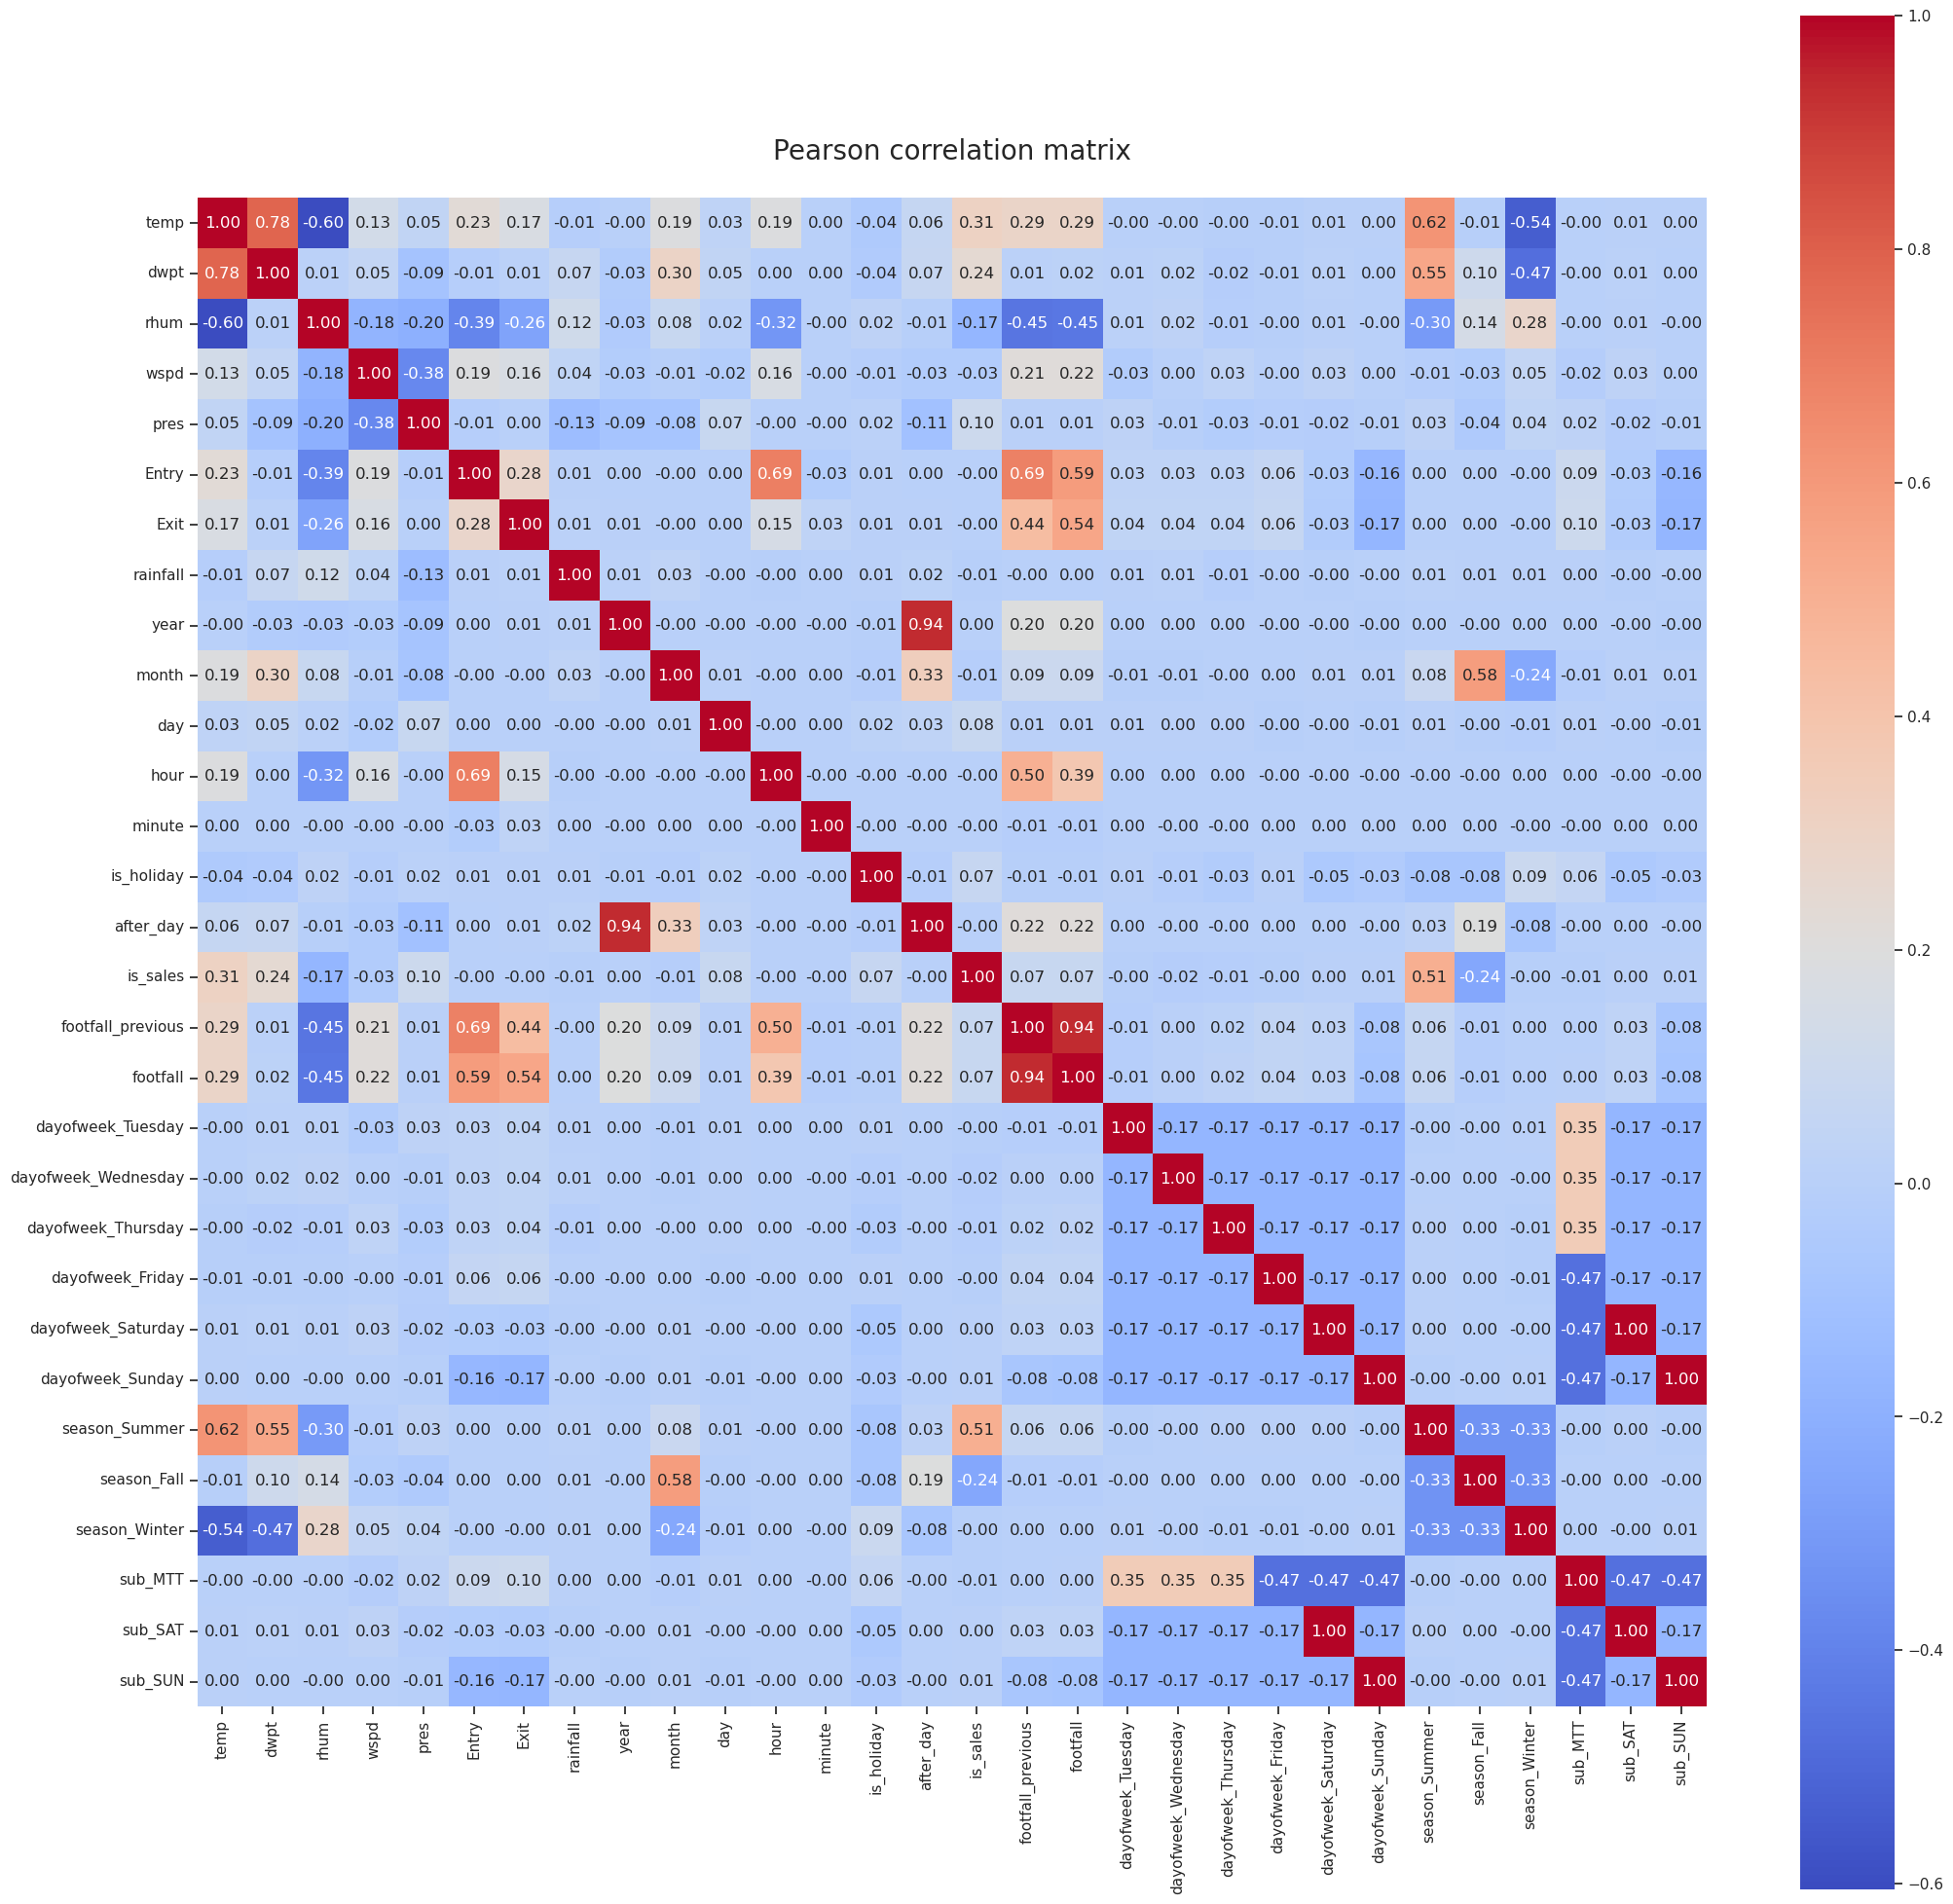

In [29]:
final_data_cor = final_data.copy()
final_data_cor = final_data_cor.drop(columns=['timestamp'])
final_data_cor['dayofweek'] = final_data_cor['dayofweek'].astype('category')
final_data_cor['season'] = final_data_cor['season'].astype('category')
final_data_cor['sub'] = final_data_cor['sub'].astype('category')

final_data_cor = pd.get_dummies(final_data_cor, columns=['dayofweek', 'season', 'sub'], drop_first=True)

final_data_cor['is_holiday'] = final_data_cor['is_holiday'].astype(int)
final_data_cor['is_sales'] = final_data_cor['is_sales'].astype(int)

correlation_matrix = final_data_cor.corr()

plt.figure(figsize=(25, 25))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Pearson correlation matrix' , fontsize=20, y=1.02)
#plt.savefig('../final_graph/correlation_matrix.png')
plt.show()

# After EDA, the dataset used is changed back to the previously divided training set and test set. The standardization and feature engineering are started.

In [30]:
X_train_filled['season'] = X_train_filled['month'].apply(get_season)
X_train_filled['dayofweek'] = X_train_filled['dayofweek'].map(dayofweek_map)
X_train_filled['sub'] = X_train_filled.apply(match_day, axis=1)
X_test_filled['season'] =X_test_filled['month'].apply(get_season)
X_test_filled['dayofweek'] = X_test_filled['dayofweek'].map(dayofweek_map)
X_test_filled['sub'] = X_test_filled.apply(match_day, axis=1)


In [31]:
X_train_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252288 entries, 0 to 252287
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   timestamp          252288 non-null  datetime64[ns]
 1   temp               252288 non-null  float64       
 2   dwpt               252288 non-null  float64       
 3   rhum               252288 non-null  int64         
 4   wspd               252288 non-null  float64       
 5   pres               252288 non-null  float64       
 6   Entry              252288 non-null  float64       
 7   Exit               252288 non-null  float64       
 8   rainfall           252288 non-null  float64       
 9   year               252288 non-null  int32         
 10  month              252288 non-null  int32         
 11  day                252288 non-null  int32         
 12  hour               252288 non-null  int32         
 13  minute             252288 non-null  int32   

In [32]:
# One-hot encode categorical features
X_train_final = pd.get_dummies(X_train_filled, columns=['dayofweek','season', 'sub'], drop_first=True)
X_test_final = pd.get_dummies(X_test_filled, columns=['dayofweek','season', 'sub'], drop_first=True)


In [33]:
X_train_final_filled = X_train_final.drop(columns=['timestamp'])
X_test_final_filled = X_test_final.drop(columns=['timestamp'])
y_train_filled_filled = y_train_filled.drop(columns=['timestamp'])
y_test_filled_filled = y_test_filled.drop(columns=['timestamp'])


In [34]:
X_train_final_filled.info(), X_test_final_filled.info(), y_train_filled_filled.info(), y_test_filled_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252288 entries, 0 to 252287
Data columns (total 29 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   temp                 252288 non-null  float64
 1   dwpt                 252288 non-null  float64
 2   rhum                 252288 non-null  int64  
 3   wspd                 252288 non-null  float64
 4   pres                 252288 non-null  float64
 5   Entry                252288 non-null  float64
 6   Exit                 252288 non-null  float64
 7   rainfall             252288 non-null  float64
 8   year                 252288 non-null  int32  
 9   month                252288 non-null  int32  
 10  day                  252288 non-null  int32  
 11  hour                 252288 non-null  int32  
 12  minute               252288 non-null  int32  
 13  is_holiday           252288 non-null  bool   
 14  after_day            252288 non-null  int64  
 15  is_sales         

(None, None, None, None)

In [35]:
full_columns = X_train_final_filled.columns
full_columns

Index(['temp', 'dwpt', 'rhum', 'wspd', 'pres', 'Entry', 'Exit', 'rainfall',
       'year', 'month', 'day', 'hour', 'minute', 'is_holiday', 'after_day',
       'is_sales', 'footfall_previous', 'dayofweek_Monday',
       'dayofweek_Saturday', 'dayofweek_Sunday', 'dayofweek_Thursday',
       'dayofweek_Tuesday', 'dayofweek_Wednesday', 'season_Spring',
       'season_Summer', 'season_Winter', 'sub_MTT', 'sub_SAT', 'sub_SUN'],
      dtype='object')

# try only footfall

In [36]:
only_footfall_features = ['month', 'day', 'hour', 'minute', 'is_holiday', 'after_day',
    'dayofweek_Monday', 'dayofweek_Thursday',
    'dayofweek_Tuesday', 'dayofweek_Wednesday', 'season_Spring', 'season_Summer', 'season_Winter',
    'sub_MTT', 'sub_SAT', 'sub_SUN', 'is_sales']

X_train_final_filled_onlyfootfall = X_train_final_filled[only_footfall_features]
X_test_final_filled_onlyfootfall = X_test_final_filled[only_footfall_features]

In [37]:
# from sklearn.model_selection import GridSearchCV
# from xgboost import XGBRegressor

# param_grid = {
#     'n_estimators': [20, 30, 40, 50],
#     'max_depth': [2, 3, 4],
#     'learning_rate': [0.04, 0.05, 0.06]
# }

# model = XGBRegressor()

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5, verbose=1)
# grid_search.fit(X_train_final_filled_onlyfootfall, y_train_filled_filled)

# print("Best parameters found: ", grid_search.best_params_)
# print("Best R²: ", grid_search.best_score_)


In [38]:
# param_grid_further = {
#     'min_child_weight': [0, 0.01],
#     'gamma': [0, 0.01]
# }

# model_further = XGBRegressor(
#     random_state=42,
#     objective='reg:squarederror',
#     learning_rate=0.05,
#     max_depth=3,
#     n_estimators=40
# )

# grid_search_further = GridSearchCV(estimator=model_further, param_grid=param_grid_further, scoring='r2', cv=5, verbose=1)
# grid_search_further.fit(X_train_final_filled_onlyfootfall, y_train_filled_filled)

# print("Best parameters found for min_child_weight and gamma: ", grid_search_further.best_params_)
# print("Best R² for min_child_weight and gamma: ", grid_search_further.best_score_)

In [39]:
# param_grid_sub_col = {
#     'subsample': [0.2, 0.3, 0.4, 0.5],
#     'colsample_bytree': [0.8, 1.0, 1.2]
# }

# model_sub_col = XGBRegressor(
#     random_state=42,
#     objective='reg:squarederror',
#     learning_rate=0.05,
#     max_depth=3,
#     n_estimators=40,
#     gamma=0,
#     min_child_weight=0
# )

# grid_search_sub_col = GridSearchCV(estimator=model_sub_col, param_grid=param_grid_sub_col, scoring='r2', cv=5, verbose=1)
# grid_search_sub_col.fit(X_train_final_filled_onlyfootfall, y_train_filled_filled)

# print("Best parameters found for subsample and colsample_bytree: ", grid_search_sub_col.best_params_)
# print("Best R² for subsample and colsample_bytree: ", grid_search_sub_col.best_score_)

In [40]:
# param_grid_reg = {
#     'reg_alpha': [0, 0.01, 0.02],
#     'reg_lambda': [10, 20, 30]
# }

# model_reg = XGBRegressor(
#     random_state=42,
#     objective='reg:squarederror',
#     learning_rate=0.05,
#     max_depth=3,
#     n_estimators=40,
#     gamma=0,
#     min_child_weight=0,
#     subsample=0.4,
#     colsample_bytree=1.0
# )

# grid_search_reg = GridSearchCV(estimator=model_reg, param_grid=param_grid_reg, scoring='r2', cv=5, verbose=1)
# grid_search_reg.fit(X_train_final_filled_onlyfootfall, y_train_filled_filled)

# print("Best parameters found for reg_alpha and reg_lambda: ", grid_search_reg.best_params_)
# print("Best R² for reg_alpha and reg_lambda: ", grid_search_reg.best_score_)

In [41]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

best_xgb_onlyfootfall = XGBRegressor(
    random_state=42,
    objective='reg:squarederror',
    learning_rate=0.05,
    max_depth=3,
    n_estimators=40,
    gamma=0,
    min_child_weight=0,
    subsample=0.4,
    colsample_bytree=1.0,
    reg_alpha=0.01,
    reg_lambda=20
)

best_xgb_onlyfootfall.fit(X_train_final_filled_onlyfootfall, y_train_filled_filled)

train_preds = best_xgb_onlyfootfall.predict(X_train_final_filled_onlyfootfall)
test_preds = best_xgb_onlyfootfall.predict(X_test_final_filled_onlyfootfall)

train_r2 = r2_score(y_train_filled_filled, train_preds)
test_r2 = r2_score(y_test_filled_filled, test_preds)
train_rmse = mean_squared_error(y_train_filled_filled, train_preds, squared=False)
test_rmse = mean_squared_error(y_test_filled_filled, test_preds, squared=False)
# Calculate MAPE
train_mape = mean_absolute_percentage_error(y_train_filled_filled, train_preds)
test_mape = mean_absolute_percentage_error(y_test_filled_filled, test_preds)

print("Final XGBoost model performance:")
print(f"Train R2: {train_r2}")
print(f"Test R2: {test_r2}")
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train MAPE: {train_mape}")
print(f"Test MAPE: {test_mape}")

/opt/conda/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/opt/conda/li

Final XGBoost model performance:
Train R2: 0.81784198963517
Test R2: 0.6044544858615475
Train RMSE: 182.37945762594762
Test RMSE: 329.31795195618696
Train MAPE: 85938039849110.62
Test MAPE: 1.1887148056130488e+17


<Figure size 1000x1000 with 0 Axes>

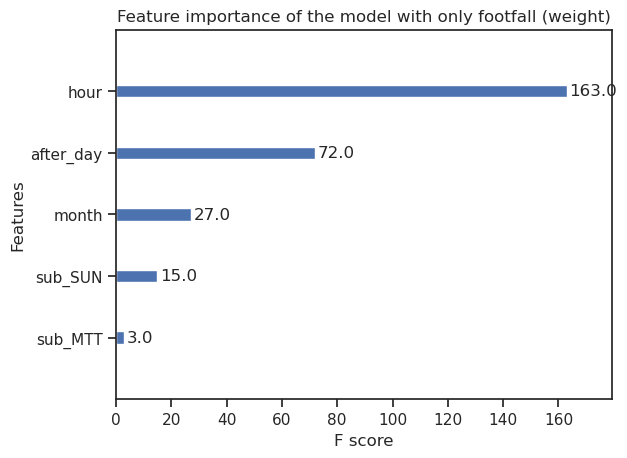

In [42]:
from xgboost import plot_importance

plt.figure(figsize=(10, 10))
plot_importance(best_xgb_onlyfootfall, importance_type='weight', max_num_features=len(best_xgb_onlyfootfall.get_booster().feature_names))
plt.title('Feature importance of the model with only footfall (weight)')
plt.grid(False)
plt.savefig('../final_graph/importance_onlyfootfall.png')
plt.show()

In [43]:
import datetime

def create_future_dates(start_date, periods):
    return pd.date_range(start=start_date, periods=periods, freq='5T')

# 创建特征函数
def create_features(dates, start_timestamp):
    features = pd.DataFrame({
#        'year': dates.year,
        'month': dates.month,
        'day': dates.day,
        'hour': dates.hour,
        'minute': dates.minute,
        'is_holiday': dates.map(lambda x: x.date() in uk_holidays),
        'after_day': (dates - datetime.datetime(2017, 1, 1)).days + 1
    })
    
    features['dayofweek'] = dates.weekday.map(dayofweek_map)
    features['season'] = features['month'].apply(get_season)
    features['sub'] = features.apply(match_day, axis=1)
    features['is_sales'] = True
    
    return features

start_date = pd.to_datetime('2025-07-01')
start_timestamp = pd.to_datetime('2025-07-01 00:00:00')
future_dates_weekly_onlyfootfall = create_future_dates(start_date, 7 * 24 * 12)
future_dates_monthly_onlyfootfall = create_future_dates(start_date, 31 * 24 * 12)

future_features_weekly_onlyfootfall = create_features(future_dates_weekly_onlyfootfall, start_timestamp)
future_features_monthly_onlyfootfall = create_features(future_dates_monthly_onlyfootfall, start_timestamp)

In [44]:
future_features_weekly_onlyfootfall.info(), future_features_monthly_onlyfootfall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   month       2016 non-null   int32 
 1   day         2016 non-null   int32 
 2   hour        2016 non-null   int32 
 3   minute      2016 non-null   int32 
 4   is_holiday  2016 non-null   bool  
 5   after_day   2016 non-null   int64 
 6   dayofweek   2016 non-null   object
 7   season      2016 non-null   object
 8   sub         2016 non-null   object
 9   is_sales    2016 non-null   bool  
dtypes: bool(2), int32(4), int64(1), object(3)
memory usage: 98.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8928 entries, 0 to 8927
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   month       8928 non-null   int32 
 1   day         8928 non-null   int32 
 2   hour        8928 non-null   int32 
 3   minute      8928 non-null   int

(None, None)

In [45]:
future_features_weekly_onlyfootfall = pd.get_dummies(future_features_weekly_onlyfootfall, columns=['dayofweek', 'sub'], drop_first=True)
future_features_monthly_onlyfootfall = pd.get_dummies(future_features_monthly_onlyfootfall, columns=['dayofweek', 'sub'], drop_first=True)
future_features_weekly_onlyfootfall = pd.get_dummies(future_features_weekly_onlyfootfall, columns=['season'], drop_first=False)
future_features_monthly_onlyfootfall = pd.get_dummies(future_features_monthly_onlyfootfall, columns=['season'], drop_first=False)

In [46]:
future_features_weekly_onlyfootfall.info(), future_features_monthly_onlyfootfall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   month                2016 non-null   int32
 1   day                  2016 non-null   int32
 2   hour                 2016 non-null   int32
 3   minute               2016 non-null   int32
 4   is_holiday           2016 non-null   bool 
 5   after_day            2016 non-null   int64
 6   is_sales             2016 non-null   bool 
 7   dayofweek_Monday     2016 non-null   bool 
 8   dayofweek_Saturday   2016 non-null   bool 
 9   dayofweek_Sunday     2016 non-null   bool 
 10  dayofweek_Thursday   2016 non-null   bool 
 11  dayofweek_Tuesday    2016 non-null   bool 
 12  dayofweek_Wednesday  2016 non-null   bool 
 13  sub_MTT              2016 non-null   bool 
 14  sub_SAT              2016 non-null   bool 
 15  sub_SUN              2016 non-null   bool 
 16  season_Summer        201

(None, None)

In [47]:
season_columns = ['season_Spring', 'season_Winter']
for col in season_columns:
    if col not in future_features_weekly_onlyfootfall.columns:
        future_features_weekly_onlyfootfall[col] = False
    if col not in future_features_monthly_onlyfootfall.columns:
        future_features_monthly_onlyfootfall[col] = False
future_features_weekly_onlyfootfall.info(), future_features_monthly_onlyfootfall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   month                2016 non-null   int32
 1   day                  2016 non-null   int32
 2   hour                 2016 non-null   int32
 3   minute               2016 non-null   int32
 4   is_holiday           2016 non-null   bool 
 5   after_day            2016 non-null   int64
 6   is_sales             2016 non-null   bool 
 7   dayofweek_Monday     2016 non-null   bool 
 8   dayofweek_Saturday   2016 non-null   bool 
 9   dayofweek_Sunday     2016 non-null   bool 
 10  dayofweek_Thursday   2016 non-null   bool 
 11  dayofweek_Tuesday    2016 non-null   bool 
 12  dayofweek_Wednesday  2016 non-null   bool 
 13  sub_MTT              2016 non-null   bool 
 14  sub_SAT              2016 non-null   bool 
 15  sub_SUN              2016 non-null   bool 
 16  season_Summer        201

(None, None)

In [48]:
future_features_weekly_onlyfootfall = future_features_weekly_onlyfootfall.drop(columns=['dayofweek_Saturday', 'dayofweek_Sunday'])
future_features_monthly_onlyfootfall = future_features_monthly_onlyfootfall.drop(columns=['dayofweek_Saturday', 'dayofweek_Sunday'])

In [49]:
future_features_weekly_onlyfootfall = future_features_weekly_onlyfootfall.reindex(columns=X_train_final_filled_onlyfootfall.columns, fill_value=0)
future_features_monthly_onlyfootfall = future_features_monthly_onlyfootfall.reindex(columns=X_train_final_filled_onlyfootfall.columns, fill_value=0)

future_features_weekly_onlyfootfall_preds = best_xgb_onlyfootfall.predict(future_features_weekly_onlyfootfall)
future_features_monthly_onlyfootfall_preds = best_xgb_onlyfootfall.predict(future_features_monthly_onlyfootfall)


/opt/conda/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/opt/conda/li

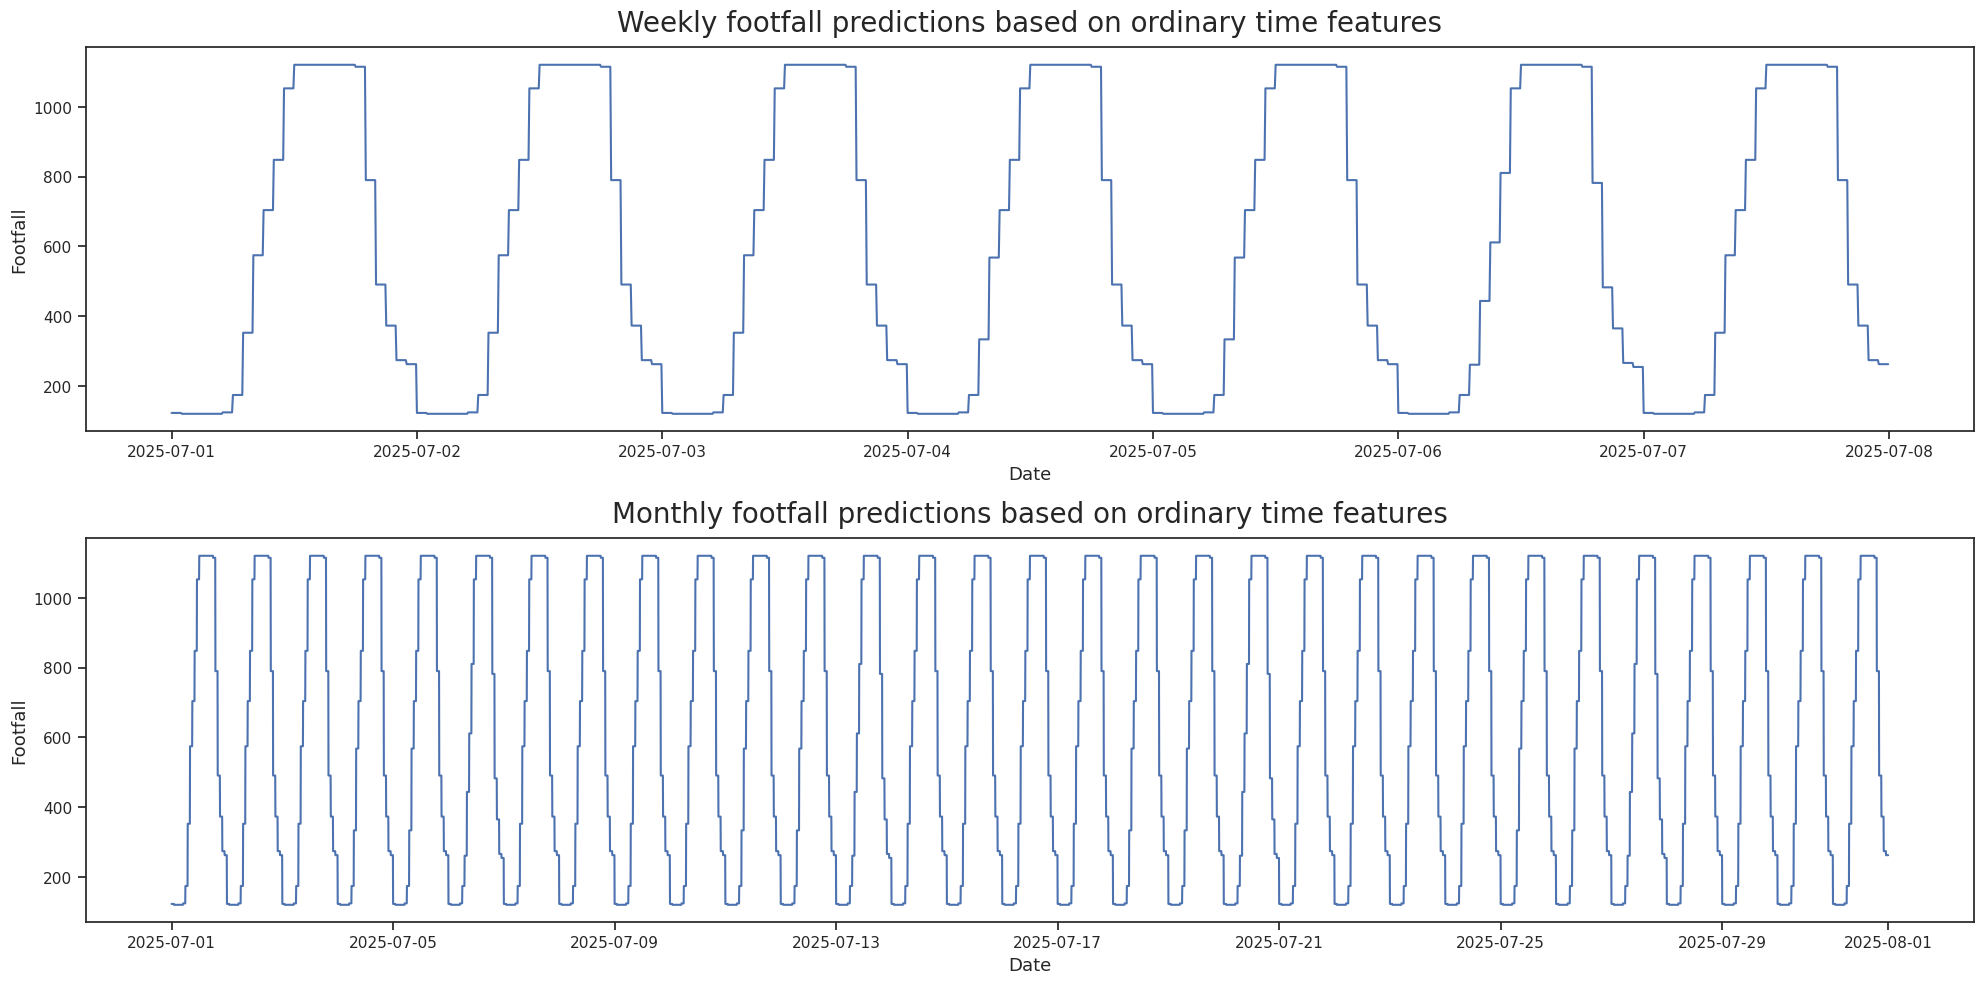

In [50]:
future_features_weekly_onlyfootfall_preds_results = pd.DataFrame({'timestamp': future_dates_weekly_onlyfootfall, 'predicted_footfall': future_features_weekly_onlyfootfall_preds})
future_features_monthly_onlyfootfall_preds_results = pd.DataFrame({'timestamp': future_dates_monthly_onlyfootfall, 'predicted_footfall': future_features_monthly_onlyfootfall_preds})

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
#plt.plot(y_test_filled['timestamp'], y_test_filled['footfall_filled'], label='Actual Footfall', color='blue')
plt.plot(future_features_weekly_onlyfootfall_preds_results['timestamp'], future_features_weekly_onlyfootfall_preds_results['predicted_footfall'], label='Weekly Predicted Footfall')
plt.title('Weekly footfall predictions based on ordinary time features', fontsize=20, y=1.02)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Footfall', fontsize=13)
#plt.legend()

plt.subplot(2, 1, 2)
plt.plot(future_features_monthly_onlyfootfall_preds_results['timestamp'], future_features_monthly_onlyfootfall_preds_results['predicted_footfall'], label='Monthly Predicted Footfall')
plt.title('Monthly footfall predictions based on ordinary time features', fontsize=20, y=1.02)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Footfall', fontsize=13)
#plt.legend()

plt.tight_layout()
#plt.savefig('../final_graph/onlyfootfall_preds.png')
plt.show()

# footfall+footfall_previous

In [51]:
footfall_previous_features = ['month', 'day', 'hour', 'minute', 'is_holiday', 'after_day',
    'dayofweek_Monday', 'dayofweek_Thursday',
    'dayofweek_Tuesday', 'dayofweek_Wednesday', 'season_Spring', 'season_Summer', 'season_Winter',
    'sub_MTT', 'sub_SAT', 'sub_SUN', 'is_sales', 'footfall_previous']

X_train_final_filled_footfallprevious = X_train_final_filled[footfall_previous_features]
X_test_final_filled_footfallprevious = X_test_final_filled[footfall_previous_features]

In [52]:
# from sklearn.model_selection import GridSearchCV
# from xgboost import XGBRegressor

# param_grid = {
#     'n_estimators': [150, 180,200,220],
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.04, 0.05, 0.06]
# }

# model = XGBRegressor()

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5, verbose=1)
# grid_search.fit(X_train_final_filled_footfallprevious, y_train_filled_filled)

# print("Best parameters found: ", grid_search.best_params_)
# print("Best R²: ", grid_search.best_score_)


In [53]:
# param_grid_further = {
#     'min_child_weight': [0, 0.01],
#     'gamma': [0, 0.01]
# }

# model_further = XGBRegressor(
#     random_state=42,
#     objective='reg:squarederror',
#     learning_rate=0.05,
#     max_depth=4,
#     n_estimators=200
# )

# grid_search_further = GridSearchCV(estimator=model_further, param_grid=param_grid_further, scoring='r2', cv=5, verbose=1)
# grid_search_further.fit(X_train_final_filled_footfallprevious, y_train_filled_filled)

# print("Best parameters found for min_child_weight and gamma: ", grid_search_further.best_params_)
# print("Best R² for min_child_weight and gamma: ", grid_search_further.best_score_)

In [54]:
# param_grid_sub_col = {
#     'subsample': [0, 0.1, 0.2, 0.3],
#     'colsample_bytree': [0.7, 0.8, 0.9]
# }

# model_sub_col = XGBRegressor(
#     random_state=42,
#     objective='reg:squarederror',
#     learning_rate=0.05,
#     max_depth=4,
#     n_estimators=200,
#     gamma=0,
#     min_child_weight=0
# )

# grid_search_sub_col = GridSearchCV(estimator=model_sub_col, param_grid=param_grid_sub_col, scoring='r2', cv=5, verbose=1)
# grid_search_sub_col.fit(X_train_final_filled_footfallprevious, y_train_filled_filled)

# print("Best parameters found for subsample and colsample_bytree: ", grid_search_sub_col.best_params_)
# print("Best R² for subsample and colsample_bytree: ", grid_search_sub_col.best_score_)

In [55]:
# param_grid_reg = {
#     'reg_alpha': [0, 0.005],
#     'reg_lambda': [5,6,7,8]
# }

# model_reg = XGBRegressor(
#     random_state=42,
#     objective='reg:squarederror',
#     learning_rate=0.05,
#     max_depth=4,
#     n_estimators=200,
#     gamma=0,
#     min_child_weight=0,
#     subsample=0.2,
#     colsample_bytree=0.8
# )

# grid_search_reg = GridSearchCV(estimator=model_reg, param_grid=param_grid_reg, scoring='r2', cv=5, verbose=1)
# grid_search_reg.fit(X_train_final_filled_footfallprevious, y_train_filled_filled)

# print("Best parameters found for reg_alpha and reg_lambda: ", grid_search_reg.best_params_)
# print("Best R² for reg_alpha and reg_lambda: ", grid_search_reg.best_score_)

In [56]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

best_xgb_footfallprevious = XGBRegressor(
    random_state=42,
    objective='reg:squarederror',
    learning_rate=0.05,
    max_depth=4,
    n_estimators=200,
    gamma=0,
    min_child_weight=0,
    subsample=0.2,
    colsample_bytree=0.8,
    reg_alpha=0,
    reg_lambda=7
)

best_xgb_footfallprevious.fit(X_train_final_filled_footfallprevious, y_train_filled_filled)

train_preds = best_xgb_footfallprevious.predict(X_train_final_filled_footfallprevious)
test_preds = best_xgb_footfallprevious.predict(X_test_final_filled_footfallprevious)

train_r2 = r2_score(y_train_filled_filled, train_preds)
test_r2 = r2_score(y_test_filled_filled, test_preds)
train_rmse = mean_squared_error(y_train_filled_filled, train_preds, squared=False)
test_rmse = mean_squared_error(y_test_filled_filled, test_preds, squared=False)

print("Final XGBoost model performance:")
print(f"Train R2: {train_r2}")
print(f"Test R2: {test_r2}")
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

/opt/conda/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/opt/conda/li

Final XGBoost model performance:
Train R2: 0.9607920231907217
Test R2: 0.9037375343856454
Train RMSE: 84.61337128003493
Test RMSE: 162.4597066491018


/opt/conda/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


<Figure size 1500x2500 with 0 Axes>

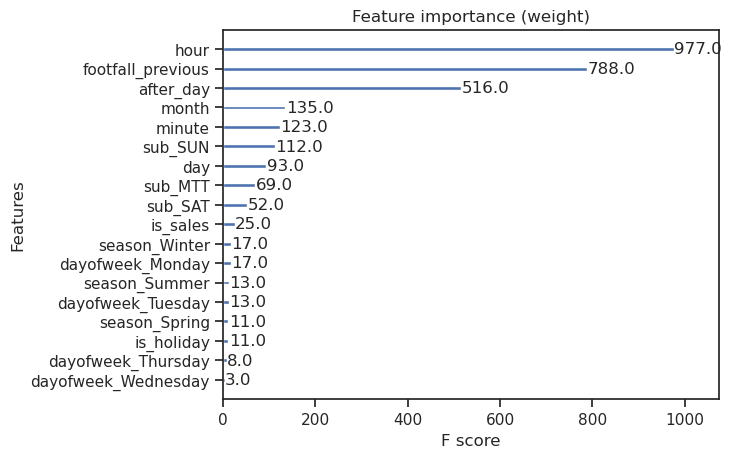

In [57]:
from xgboost import plot_importance

plt.figure(figsize=(15, 25))
plot_importance(best_xgb_footfallprevious, importance_type='weight', max_num_features=len(best_xgb_footfallprevious.get_booster().feature_names))
plt.title('Feature importance (weight)')
plt.grid(False)
#plt.savefig('../final_graph/importance_footfallprevious.png')
plt.show()

In [58]:
start_date = pd.to_datetime('2025-07-01')
start_timestamp = pd.to_datetime('2025-07-01 00:00:00')
future_dates_weekly_footfallprevious = create_future_dates(start_date, 7 * 24 * 12)
future_dates_monthly_footfallprevious = create_future_dates(start_date, 31 * 24 * 12)

future_features_weekly_footfallprevious = create_features(future_dates_weekly_footfallprevious, start_timestamp)
future_features_monthly_footfallprevious = create_features(future_dates_monthly_footfallprevious, start_timestamp)

future_features_weekly_footfallprevious = pd.get_dummies(future_features_weekly_footfallprevious, columns=['dayofweek', 'sub'], drop_first=True)
future_features_monthly_footfallprevious = pd.get_dummies(future_features_monthly_footfallprevious, columns=['dayofweek', 'sub'], drop_first=True)
future_features_weekly_footfallprevious = pd.get_dummies(future_features_weekly_footfallprevious, columns=['season'], drop_first=False)
future_features_monthly_footfallprevious = pd.get_dummies(future_features_monthly_footfallprevious, columns=['season'], drop_first=False)

season_columns = ['season_Spring', 'season_Winter']
for col in season_columns:
    if col not in future_features_weekly_footfallprevious.columns:
        future_features_weekly_footfallprevious[col] = False
    if col not in future_features_monthly_footfallprevious.columns:
        future_features_monthly_footfallprevious[col] = False
future_features_weekly_footfallprevious.info(), future_features_monthly_footfallprevious.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   month                2016 non-null   int32
 1   day                  2016 non-null   int32
 2   hour                 2016 non-null   int32
 3   minute               2016 non-null   int32
 4   is_holiday           2016 non-null   bool 
 5   after_day            2016 non-null   int64
 6   is_sales             2016 non-null   bool 
 7   dayofweek_Monday     2016 non-null   bool 
 8   dayofweek_Saturday   2016 non-null   bool 
 9   dayofweek_Sunday     2016 non-null   bool 
 10  dayofweek_Thursday   2016 non-null   bool 
 11  dayofweek_Tuesday    2016 non-null   bool 
 12  dayofweek_Wednesday  2016 non-null   bool 
 13  sub_MTT              2016 non-null   bool 
 14  sub_SAT              2016 non-null   bool 
 15  sub_SUN              2016 non-null   bool 
 16  season_Summer        201

(None, None)

In [59]:
future_features_weekly_footfallprevious = future_features_weekly_footfallprevious.drop(columns=['dayofweek_Saturday', 'dayofweek_Sunday'])
future_features_monthly_footfallprevious = future_features_monthly_footfallprevious.drop(columns=['dayofweek_Saturday', 'dayofweek_Sunday'])

In [60]:
future_features_weekly_footfallprevious['footfall_previous'] = np.nan
future_features_monthly_footfallprevious['footfall_previous'] = np.nan


In [61]:
future_features_weekly_footfallprevious.head()

month  day  hour  minute  is_holiday  after_day  is_sales  \
0      7    1     0       0       False       3104      True   
1      7    1     0       5       False       3104      True   
2      7    1     0      10       False       3104      True   
3      7    1     0      15       False       3104      True   
4      7    1     0      20       False       3104      True   

   dayofweek_Monday  dayofweek_Thursday  dayofweek_Tuesday  \
0             False               False               True   
1             False               False               True   
2             False               False               True   
3             False               False               True   
4             False               False               True   

   dayofweek_Wednesday  sub_MTT  sub_SAT  sub_SUN  season_Summer  \
0                False     True    False    False           True   
1                False     True    False    False           True   
2                False     True    False    False           True   
3                False     True    False    False           True   
4                False     True    False    False           True   

   season_Spring  season_Winter  footfall_previous  
0          False          False                NaN  
1          False          False                NaN  
2          False          False                NaN  
3          False          False                NaN  
4          False          False                NaN

In [62]:
def predict_footfallprevious(future_features, feature_columns):
    predicted_footfall = []
    for i in range(len(future_features)):
        if i >= 12: 
            future_features.loc[i, 'footfall_previous'] = predicted_footfall[-12]
        current_features = future_features[feature_columns].iloc[i].values.reshape(1, -1)
        current_footfall = best_xgb_footfallprevious.predict(current_features)[0]
        predicted_footfall.append(current_footfall)
    return predicted_footfall

future_features_weekly_footfallprevious_preds_results = predict_footfallprevious(future_features_weekly_footfallprevious, footfall_previous_features)
future_features_monthly_footfallprevious_preds_results = predict_footfallprevious(future_features_monthly_footfallprevious, footfall_previous_features)


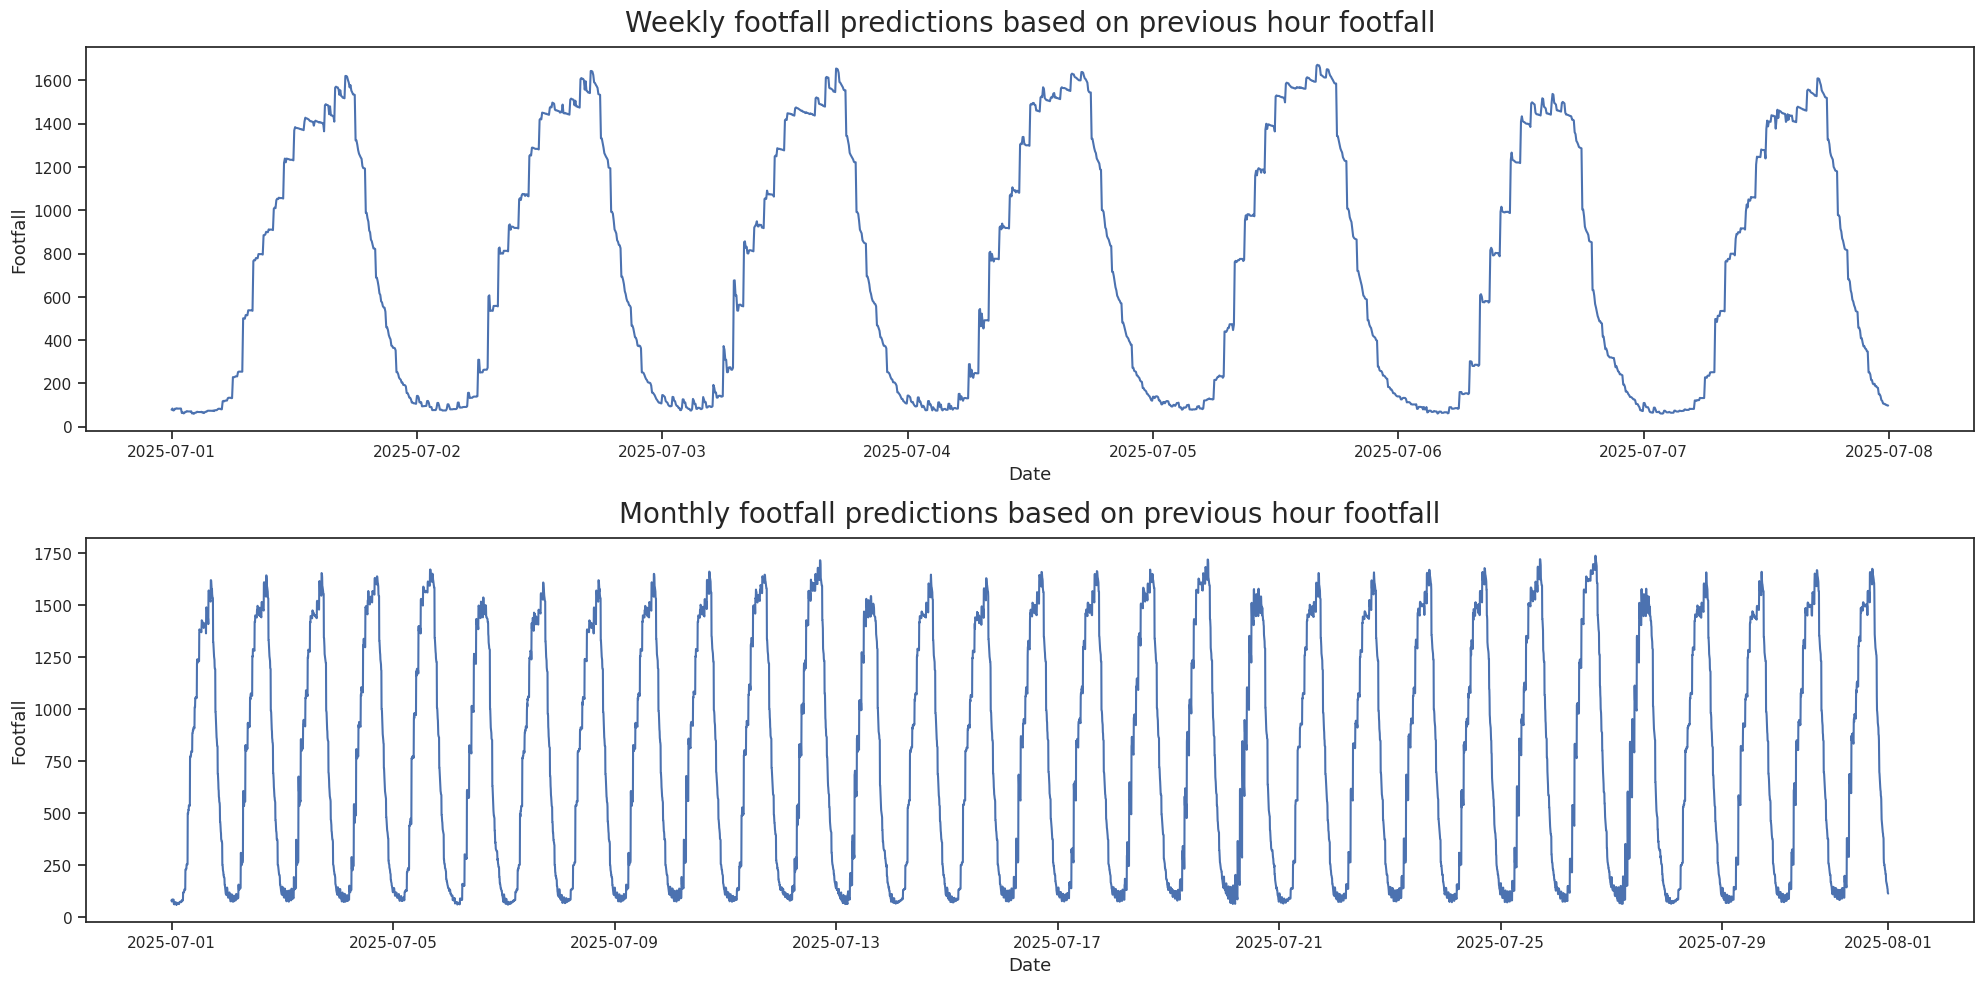

In [63]:
future_features_weekly_footfallprevious_preds_results = pd.DataFrame({'timestamp': future_dates_weekly_footfallprevious, 'predicted_footfall': future_features_weekly_footfallprevious_preds_results})
future_features_monthly_footfallprevious_preds_results = pd.DataFrame({'timestamp': future_dates_monthly_footfallprevious, 'predicted_footfall': future_features_monthly_footfallprevious_preds_results})

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
plt.plot(future_features_weekly_footfallprevious_preds_results['timestamp'], future_features_weekly_footfallprevious_preds_results['predicted_footfall'], label='Weekly Predicted Footfall')
plt.title('Weekly footfall predictions based on previous hour footfall', fontsize=20, y=1.02)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Footfall', fontsize=13)
#plt.legend()

plt.subplot(2, 1, 2)
plt.plot(future_features_monthly_footfallprevious_preds_results['timestamp'], future_features_monthly_footfallprevious_preds_results['predicted_footfall'], label='Monthly Predicted Footfall')
plt.title('Monthly footfall predictions based on previous hour footfall', fontsize=20, y=1.02)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Footfall', fontsize=13)

plt.tight_layout()
#plt.savefig('../final_graph/footfallprevious_preds.png')
plt.show()

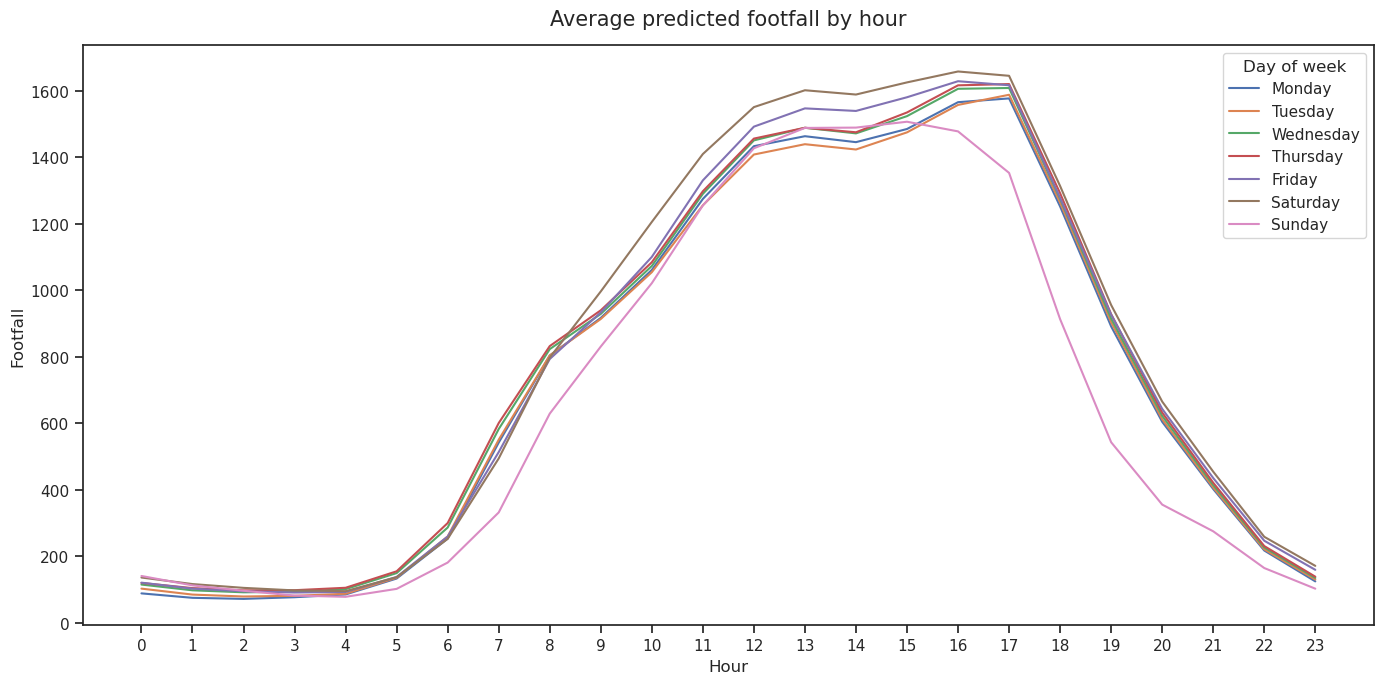

In [64]:
future_features_monthly_footfallprevious_preds_results['dayofweek'] = future_features_monthly_footfallprevious_preds_results['timestamp'].dt.day_name()
future_features_monthly_footfallprevious_preds_results['hour'] = future_features_monthly_footfallprevious_preds_results['timestamp'].dt.hour

average_footfall = future_features_monthly_footfallprevious_preds_results.groupby(['dayofweek', 'hour'])['predicted_footfall'].mean().reset_index()

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_footfall['dayofweek'] = pd.Categorical(average_footfall['dayofweek'], categories=days_order, ordered=True)
average_footfall = average_footfall.sort_values(['dayofweek', 'hour'])

plt.figure(figsize=(14, 7))

for day in days_order:
    daily_data = average_footfall[average_footfall['dayofweek'] == day]
    plt.plot(daily_data['hour'], daily_data['predicted_footfall'], label=day)

plt.title('Average predicted footfall by hour', fontsize=15, y=1.02)
plt.xlabel('Hour')
plt.ylabel('Footfall')
plt.xticks(range(0, 24, 1))  
plt.legend(title='Day of week')
plt.tight_layout()
#plt.savefig('../final_graph/average_footfallprevious_preds_by_hour_weekly.png')
plt.show()

# footfall+weather

In [65]:
footfall_weather_features = ['month', 'day', 'hour', 'minute', 'is_holiday', 'after_day', 'is_sales',
    'dayofweek_Monday', 'dayofweek_Thursday',
    'dayofweek_Tuesday', 'dayofweek_Wednesday', 'season_Spring', 'season_Summer', 'season_Winter',
    'sub_MTT', 'sub_SAT', 'sub_SUN', 'temp', 'dwpt', 'rhum', 'wspd', 'pres', 'rainfall', 'footfall_previous']

X_train_final_filled_footfallweather = X_train_final_filled[footfall_weather_features]
X_test_final_filled_footfallweather = X_test_final_filled[footfall_weather_features]

In [66]:
# from sklearn.model_selection import GridSearchCV
# from xgboost import XGBRegressor

# param_grid = {
#     'n_estimators': [80, 100, 120],
#     'max_depth': [4, 5, 6],
#     'learning_rate': [0.05, 0.06, 0.07]
# }

# model = XGBRegressor()

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5, verbose=1)
# grid_search.fit(X_train_final_filled_footfallweather, y_train_filled_filled)

# print("Best parameters found: ", grid_search.best_params_)
# print("Best R²: ", grid_search.best_score_)


In [67]:
# param_grid_further = {
#     'min_child_weight': [0, 0.01],
#     'gamma': [0, 0.01]
# }

# model_further = XGBRegressor(
#     random_state=42,
#     objective='reg:squarederror',
#     learning_rate=0.06,
#     max_depth=5,
#     n_estimators=100
# )

# grid_search_further = GridSearchCV(estimator=model_further, param_grid=param_grid_further, scoring='r2', cv=5, verbose=1)
# grid_search_further.fit(X_train_final_filled_footfallweather, y_train_filled_filled)

# print("Best parameters found for min_child_weight and gamma: ", grid_search_further.best_params_)
# print("Best R² for min_child_weight and gamma: ", grid_search_further.best_score_)

In [68]:
# param_grid_sub_col = {
#     'subsample': [0.6, 0.8, 1.0, 1.2],
#     'colsample_bytree': [0.9, 1.0, 1.1]
# }

# model_sub_col = XGBRegressor(
#     random_state=42,
#     objective='reg:squarederror',
#     learning_rate=0.06,
#     max_depth=5,
#     n_estimators=100,
#     gamma=0,
#     min_child_weight=0
# )

# grid_search_sub_col = GridSearchCV(estimator=model_sub_col, param_grid=param_grid_sub_col, scoring='r2', cv=5, verbose=1)
# grid_search_sub_col.fit(X_train_final_filled_footfallweather, y_train_filled_filled)

# print("Best parameters found for subsample and colsample_bytree: ", grid_search_sub_col.best_params_)
# print("Best R² for subsample and colsample_bytree: ", grid_search_sub_col.best_score_)

In [69]:
# param_grid_reg = {
#     'reg_alpha': [0, 0.01, 0.02],
#     'reg_lambda': [2,3,4]
# }

# model_reg = XGBRegressor(
#     random_state=42,
#     objective='reg:squarederror',
#     learning_rate=0.06,
#     max_depth=5,
#     n_estimators=100,
#     gamma=0,
#     min_child_weight=0,
#     subsample=1.0,
#     colsample_bytree=1.0
# )

# grid_search_reg = GridSearchCV(estimator=model_reg, param_grid=param_grid_reg, scoring='r2', cv=5, verbose=1)
# grid_search_reg.fit(X_train_final_filled_footfallweather, y_train_filled_filled)

# print("Best parameters found for reg_alpha and reg_lambda: ", grid_search_reg.best_params_)
# print("Best R² for reg_alpha and reg_lambda: ", grid_search_reg.best_score_)

In [70]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error

best_xgb_footfallweather = XGBRegressor(
    random_state=42,
    objective='reg:squarederror',
    learning_rate=0.06,
    max_depth=5,
    n_estimators=100,
    gamma=0,
    min_child_weight=0,
    subsample=1.0,
    colsample_bytree=1.0,
    reg_alpha=0.01,
    reg_lambda=3
)

best_xgb_footfallweather.fit(X_train_final_filled_footfallweather, y_train_filled_filled)

train_preds = best_xgb_footfallweather.predict(X_train_final_filled_footfallweather)
test_preds = best_xgb_footfallweather.predict(X_test_final_filled_footfallweather)

train_r2 = r2_score(y_train_filled_filled, train_preds)
test_r2 = r2_score(y_test_filled_filled, test_preds)
train_rmse = mean_squared_error(y_train_filled_filled, train_preds, squared=False)
test_rmse = mean_squared_error(y_test_filled_filled, test_preds, squared=False)

print("Final XGBoost model performance:")
print(f"Train R2: {train_r2}")
print(f"Test R2: {test_r2}")
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

/opt/conda/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/opt/conda/li

Final XGBoost model performance:
Train R2: 0.962308057547578
Test R2: 0.9168318804165427
Train RMSE: 82.96139430987459
Test RMSE: 151.0064907918252


/opt/conda/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


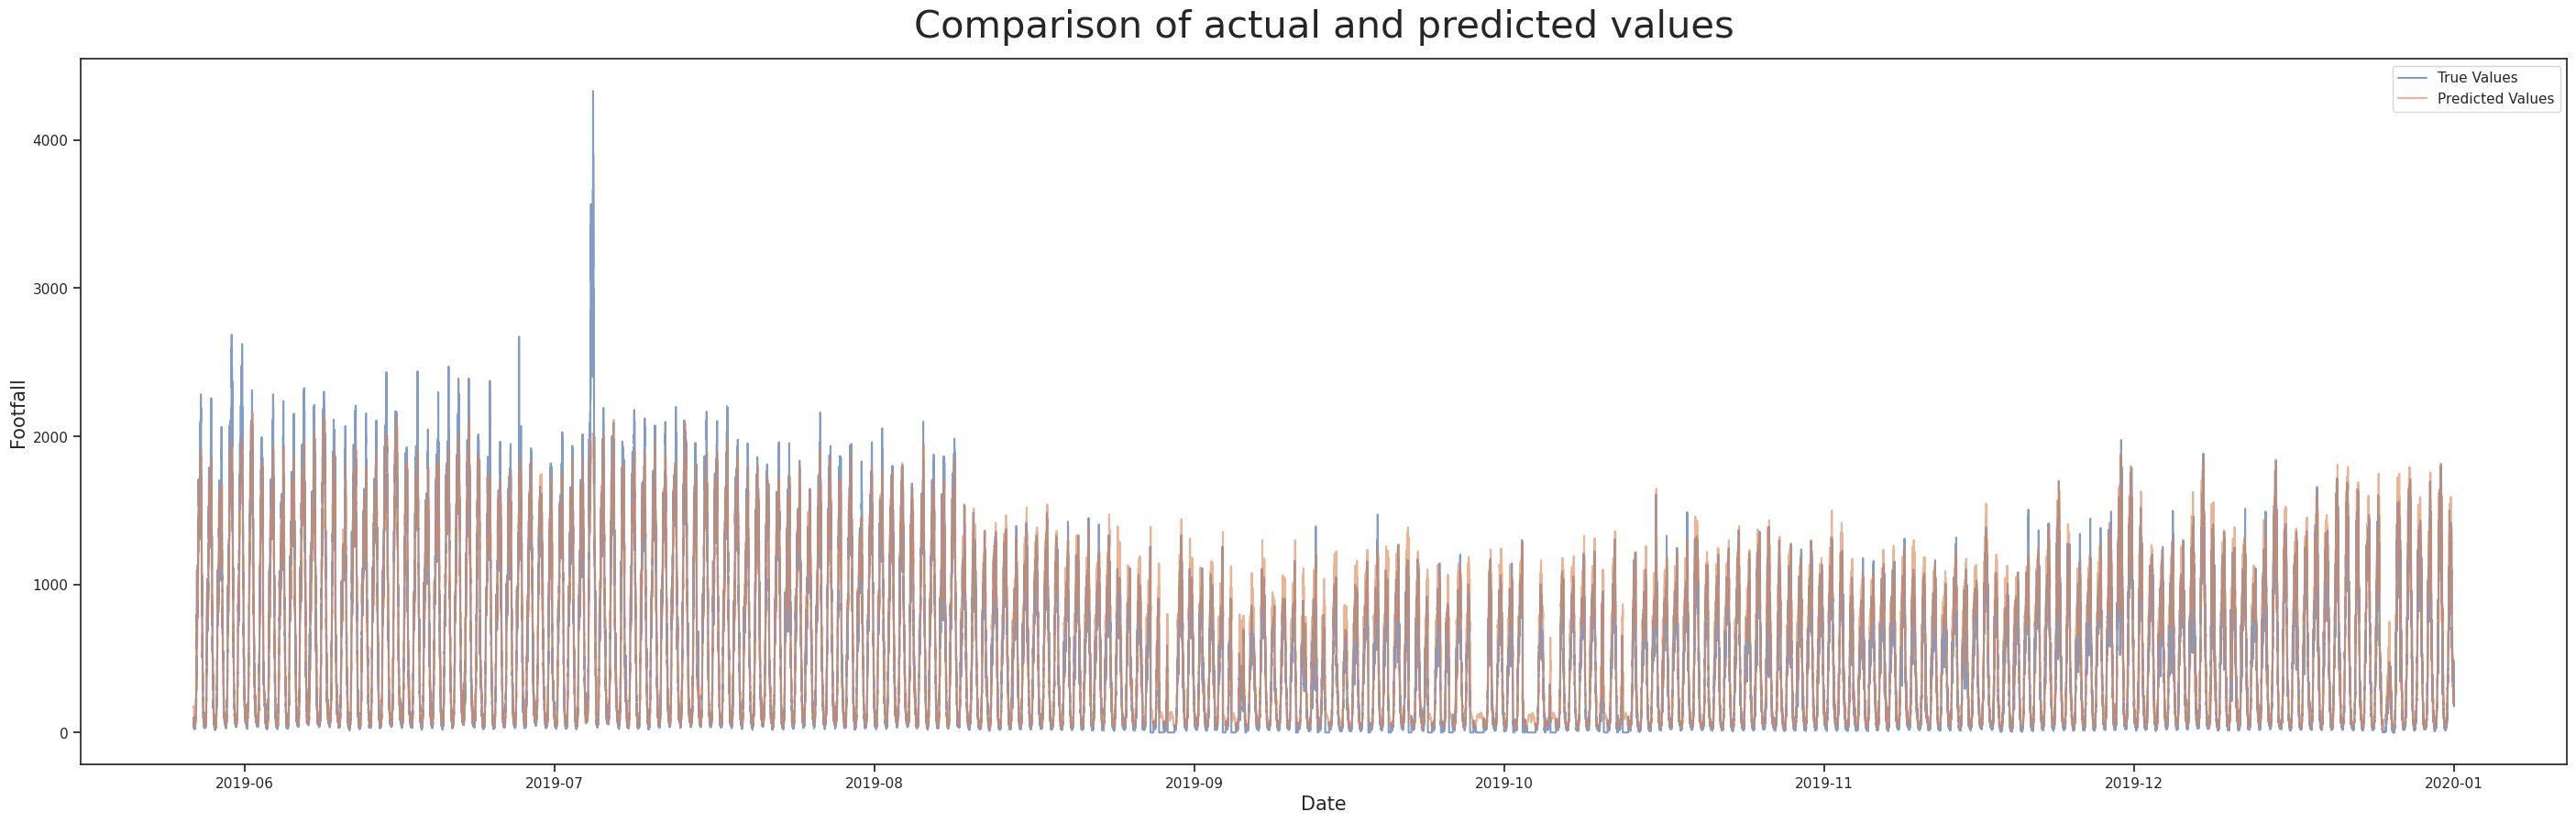

In [71]:
plt.figure(figsize=(35, 10))
plt.plot(y_test_filled['timestamp'], y_test_filled['footfall_filled'], label='True Values', alpha=0.7)
plt.plot(y_test_filled['timestamp'], test_preds, label='Predicted Values', alpha=0.6)
plt.legend()
plt.xlabel('Date',fontsize=15)
plt.ylabel('Footfall',fontsize=15)
plt.title('Comparison of actual and predicted values',fontsize=30,y=1.02)
#plt.savefig('../final_graph/predictvsactual.png')
plt.show()

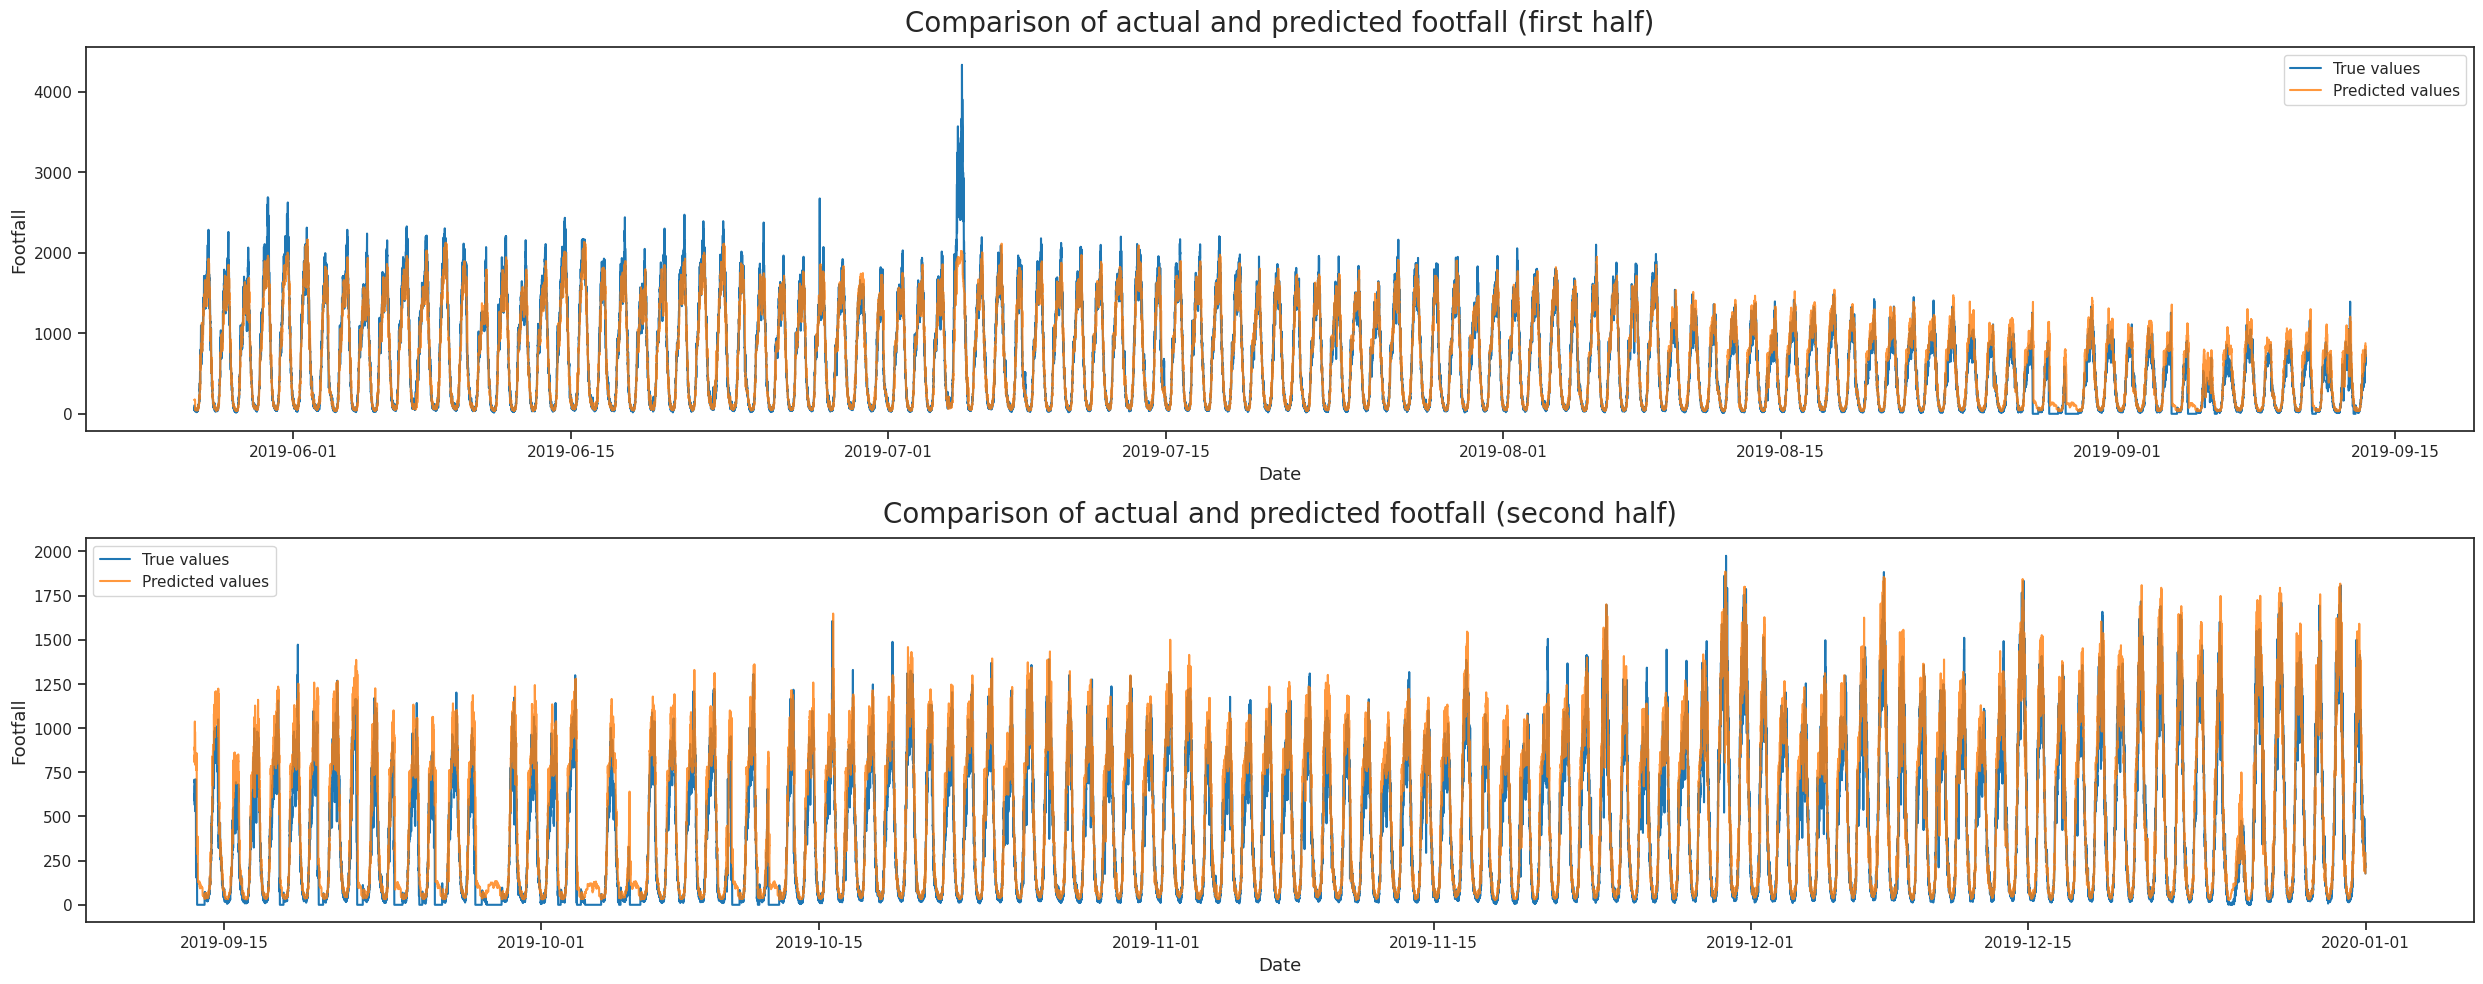

In [72]:
fig, axs = plt.subplots(2, 1, figsize=(25, 10))

axs[0].plot(y_test_filled['timestamp'][:len(y_test_filled)//2], 
            y_test_filled['footfall_filled'][:len(y_test_filled)//2], 
            label='True values', color='#1f77b4', alpha=1.0)
axs[0].plot(y_test_filled['timestamp'][:len(y_test_filled)//2], 
            test_preds[:len(y_test_filled)//2], 
            label='Predicted values', color='#ff7f0e', alpha=0.8)
axs[0].legend()
axs[0].set_xlabel('Date', fontsize=13)
axs[0].set_ylabel('Footfall', fontsize=13)
axs[0].set_title('Comparison of actual and predicted footfall (first half)', fontsize=20, y=1.02)

axs[1].plot(y_test_filled['timestamp'][len(y_test_filled)//2:], 
            y_test_filled['footfall_filled'][len(y_test_filled)//2:], 
            label='True values', color='#1f77b4', alpha=1.0)
axs[1].plot(y_test_filled['timestamp'][len(y_test_filled)//2:], 
            test_preds[len(y_test_filled)//2:], 
            label='Predicted values', color='#ff7f0e', alpha=0.8)
axs[1].legend()
axs[1].set_xlabel('Date', fontsize=13)
axs[1].set_ylabel('Footfall', fontsize=13)
axs[1].set_title('Comparison of actual and predicted footfall (second half)', fontsize=20, y=1.02)

plt.tight_layout()
#plt.savefig('../final_graph/predictvsactual_new.png')
plt.show()


<Figure size 4000x2000 with 0 Axes>

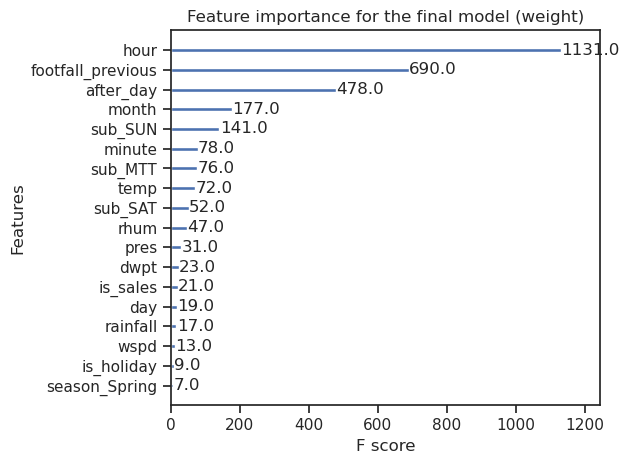

In [73]:
plt.figure(figsize=(40, 20))
plot_importance(best_xgb_footfallweather, importance_type='weight', max_num_features=len(best_xgb_footfallprevious.get_booster().feature_names))
plt.title('Feature importance for the final model (weight)')
plt.grid(False)
plt.tight_layout()
#plt.savefig('../final_graph/importance_footfallweather.png')
plt.show()

In [74]:
start_date = pd.to_datetime('2025-07-01')
start_timestamp = pd.to_datetime('2025-07-01 00:00:00')
future_dates_weekly_footfallweather = create_future_dates(start_date, 7 * 24 * 12)
future_dates_monthly_footfallweather = create_future_dates(start_date, 31 * 24 * 12)

future_features_weekly_footfallweather = create_features(future_dates_weekly_footfallweather, start_timestamp)
future_features_monthly_footfallweather = create_features(future_dates_monthly_footfallweather, start_timestamp)

future_features_weekly_footfallweather = pd.get_dummies(future_features_weekly_footfallweather, columns=['dayofweek', 'sub'], drop_first=True)
future_features_monthly_footfallweather = pd.get_dummies(future_features_monthly_footfallweather, columns=['dayofweek', 'sub'], drop_first=True)
future_features_weekly_footfallweather = pd.get_dummies(future_features_weekly_footfallweather, columns=['season'], drop_first=False)
future_features_monthly_footfallweather = pd.get_dummies(future_features_monthly_footfallweather, columns=['season'], drop_first=False)

season_columns = ['season_Spring', 'season_Winter']
for col in season_columns:
    if col not in future_features_weekly_footfallweather.columns:
        future_features_weekly_footfallweather[col] = False
    if col not in future_features_monthly_footfallweather.columns:
        future_features_monthly_footfallweather[col] = False
future_features_weekly_footfallweather.info(), future_features_monthly_footfallweather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   month                2016 non-null   int32
 1   day                  2016 non-null   int32
 2   hour                 2016 non-null   int32
 3   minute               2016 non-null   int32
 4   is_holiday           2016 non-null   bool 
 5   after_day            2016 non-null   int64
 6   is_sales             2016 non-null   bool 
 7   dayofweek_Monday     2016 non-null   bool 
 8   dayofweek_Saturday   2016 non-null   bool 
 9   dayofweek_Sunday     2016 non-null   bool 
 10  dayofweek_Thursday   2016 non-null   bool 
 11  dayofweek_Tuesday    2016 non-null   bool 
 12  dayofweek_Wednesday  2016 non-null   bool 
 13  sub_MTT              2016 non-null   bool 
 14  sub_SAT              2016 non-null   bool 
 15  sub_SUN              2016 non-null   bool 
 16  season_Summer        201

(None, None)

In [75]:
def add_weather_features(future_features, weather_data):
    weather_features = []
    for i, row in future_features.iterrows():
        date = pd.Timestamp(year=2019, month=row['month'], day=row['day'], hour=row['hour'], minute=row['minute'])
        weather_record = weather_data.loc[weather_data['timestamp'] == date]
        if not weather_record.empty:
            temp = weather_record['temp'].values[0] #+ 1  
            other_features = weather_record[['dwpt', 'rhum', 'wspd', 'pres', 'rainfall']].values[0]
            weather_features.append([temp] + list(other_features))
            # rhum = weather_record['rhum'].values[0] - 10  
            # other_features = weather_record[['temp', 'dwpt', 'wspd', 'pres', 'rainfall']].values[0]
            # weather_features.append([rhum] + list(other_features))
        else:
            weather_features.append([np.nan] * 6) 
    weather_df = pd.DataFrame(weather_features, columns=['temp',  'dwpt',  'rhum', 'wspd', 'pres', 'rainfall'])
    future_features = pd.concat([future_features.reset_index(drop=True), weather_df], axis=1)
    return future_features

future_features_weekly_footfallweather = add_weather_features(future_features_weekly_footfallweather, final_research)
future_features_monthly_footfallweather = add_weather_features(future_features_monthly_footfallweather, final_research)

future_features_weekly_footfallweather.info(), future_features_monthly_footfallweather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   month                2016 non-null   int32  
 1   day                  2016 non-null   int32  
 2   hour                 2016 non-null   int32  
 3   minute               2016 non-null   int32  
 4   is_holiday           2016 non-null   bool   
 5   after_day            2016 non-null   int64  
 6   is_sales             2016 non-null   bool   
 7   dayofweek_Monday     2016 non-null   bool   
 8   dayofweek_Saturday   2016 non-null   bool   
 9   dayofweek_Sunday     2016 non-null   bool   
 10  dayofweek_Thursday   2016 non-null   bool   
 11  dayofweek_Tuesday    2016 non-null   bool   
 12  dayofweek_Wednesday  2016 non-null   bool   
 13  sub_MTT              2016 non-null   bool   
 14  sub_SAT              2016 non-null   bool   
 15  sub_SUN              2016 non-null   b

(None, None)

In [76]:
future_features_weekly_footfallweather = future_features_weekly_footfallweather.drop(columns=['dayofweek_Saturday', 'dayofweek_Sunday'])
future_features_monthly_footfallweather = future_features_monthly_footfallweather.drop(columns=['dayofweek_Saturday', 'dayofweek_Sunday'])

In [77]:
future_features_weekly_footfallweather.head()

month  day  hour  minute  is_holiday  after_day  is_sales  \
0      7    1     0       0       False       3104      True   
1      7    1     0       5       False       3104      True   
2      7    1     0      10       False       3104      True   
3      7    1     0      15       False       3104      True   
4      7    1     0      20       False       3104      True   

   dayofweek_Monday  dayofweek_Thursday  dayofweek_Tuesday  ...  sub_SUN  \
0             False               False               True  ...    False   
1             False               False               True  ...    False   
2             False               False               True  ...    False   
3             False               False               True  ...    False   
4             False               False               True  ...    False   

   season_Summer  season_Spring  season_Winter  temp  dwpt  rhum  wspd  \
0           True          False          False  15.0  10.2  73.0  16.6   
1           True          False          False  15.0  10.2  73.0  16.6   
2           True          False          False  15.0  10.2  73.0  16.6   
3           True          False          False  15.0  10.2  73.0  16.6   
4           True          False          False  15.0  10.2  73.0  16.6   

     pres  rainfall  
0  1018.2       0.0  
1  1018.2       0.0  
2  1018.2       0.0  
3  1018.2       0.0  
4  1018.2       0.0  

[5 rows x 23 columns]

In [78]:
future_features_weekly_footfallweather['footfall_previous'] = np.nan
future_features_monthly_footfallweather['footfall_previous'] = np.nan
def predict_footfallweather(future_features, feature_columns):
    predicted_footfall = []
    for i in range(len(future_features)):
        if i >= 12:  
            future_features.loc[i, 'footfall_previous'] = predicted_footfall[-12]
        current_features = future_features[feature_columns].iloc[i].values.reshape(1, -1)
        current_footfall = best_xgb_footfallweather.predict(current_features)[0]
        predicted_footfall.append(current_footfall)
    return predicted_footfall

future_features_weekly_footfallweather_preds_results = predict_footfallweather(future_features_weekly_footfallweather, footfall_weather_features)
future_features_monthly_footfallweather_preds_results = predict_footfallweather(future_features_monthly_footfallweather, footfall_weather_features)


In [79]:
future_features_weekly_footfallweather = future_features_weekly_footfallweather.reindex(columns=X_train_final_filled_footfallweather.columns, fill_value=0)
future_features_monthly_footfallweather = future_features_monthly_footfallweather.reindex(columns=X_train_final_filled_footfallweather.columns, fill_value=0)

future_features_weekly_footfallweather_preds = best_xgb_footfallweather.predict(future_features_weekly_footfallweather)
future_features_monthly_footfallweather_preds = best_xgb_footfallweather.predict(future_features_monthly_footfallweather)


/opt/conda/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/opt/conda/li

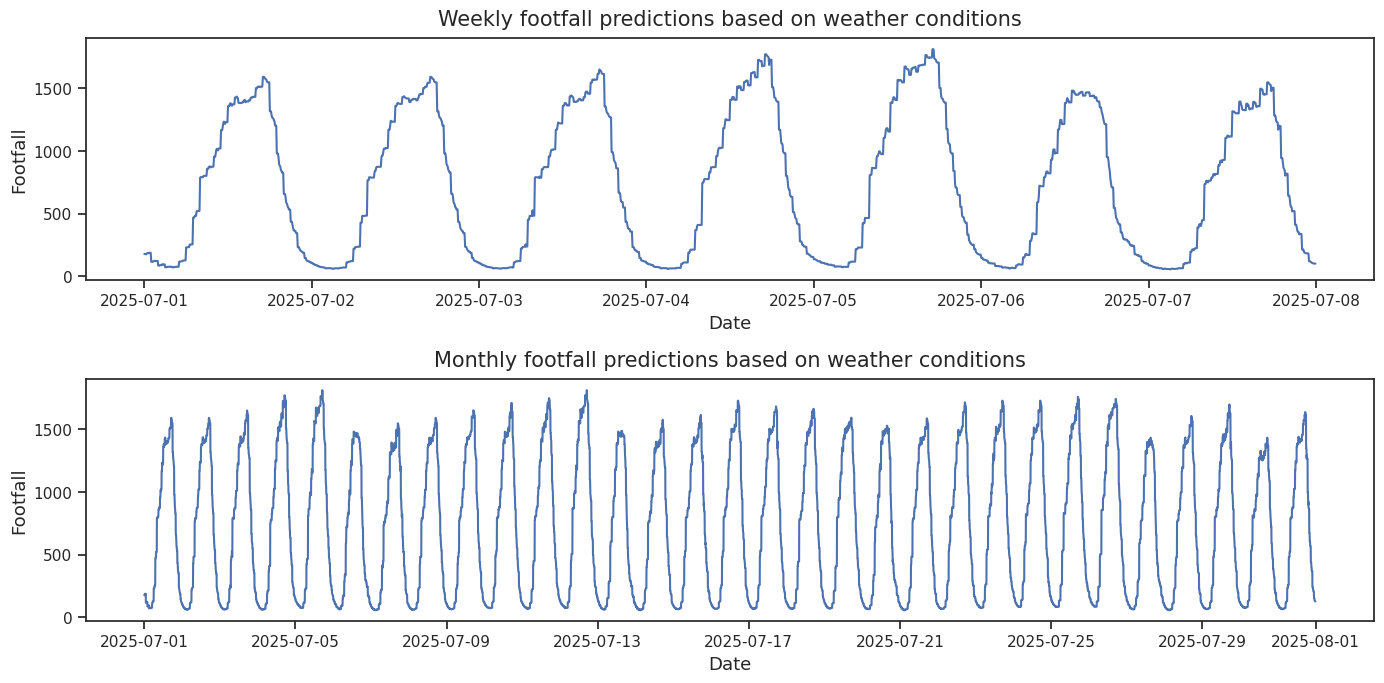

In [80]:
future_features_weekly_footfallweather_preds_results = pd.DataFrame({'timestamp': future_dates_weekly_footfallweather, 'predicted_footfall': future_features_weekly_footfallweather_preds})
future_features_monthly_footfallweather_preds_results = pd.DataFrame({'timestamp': future_dates_monthly_footfallweather, 'predicted_footfall': future_features_monthly_footfallweather_preds})

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(future_features_weekly_footfallweather_preds_results['timestamp'], future_features_weekly_footfallweather_preds_results['predicted_footfall'], label='Weekly Predicted Footfall')
plt.title('Weekly footfall predictions based on weather conditions', fontsize=15,y=1.02)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Footfall', fontsize=13)

plt.subplot(2, 1, 2)
plt.plot(future_features_monthly_footfallweather_preds_results['timestamp'], future_features_monthly_footfallweather_preds_results['predicted_footfall'], label='Monthly Predicted Footfall')
plt.title('Monthly footfall predictions based on weather conditions', fontsize=15,y=1.02)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Footfall', fontsize=13)

plt.tight_layout()
#plt.savefig('../final_graph/footfallweather_preds.png')
plt.show()

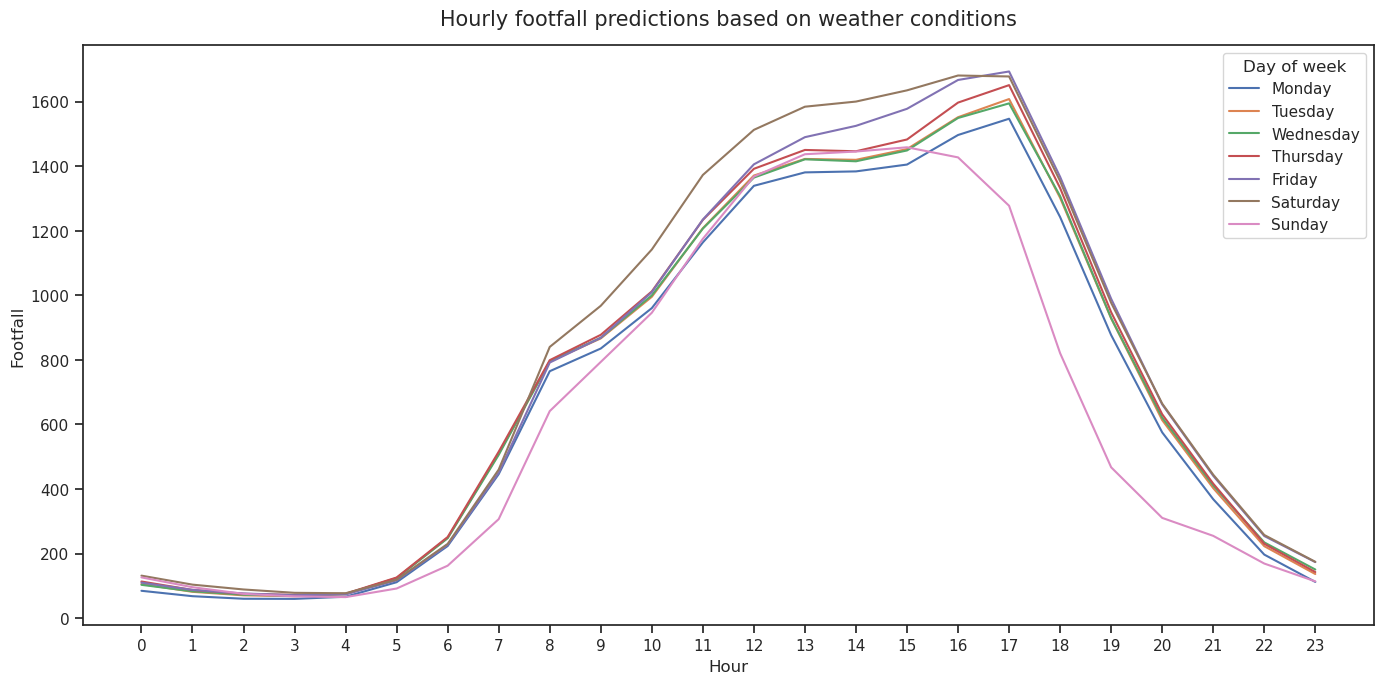

In [81]:
future_features_monthly_footfallweather_preds_results['dayofweek'] = future_features_monthly_footfallweather_preds_results['timestamp'].dt.day_name()
future_features_monthly_footfallweather_preds_results['hour'] = future_features_monthly_footfallweather_preds_results['timestamp'].dt.hour

average_footfall = future_features_monthly_footfallweather_preds_results.groupby(['dayofweek', 'hour'])['predicted_footfall'].mean().reset_index()

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_footfall['dayofweek'] = pd.Categorical(average_footfall['dayofweek'], categories=days_order, ordered=True)
average_footfall = average_footfall.sort_values(['dayofweek', 'hour'])

plt.figure(figsize=(14, 7))

for day in days_order:
    daily_data = average_footfall[average_footfall['dayofweek'] == day]
    plt.plot(daily_data['hour'], daily_data['predicted_footfall'], label=day)

plt.title('Hourly footfall predictions based on weather conditions', fontsize=15, y=1.02)
plt.xlabel('Hour')
plt.ylabel('Footfall')
plt.xticks(range(0, 24, 1)) 
plt.legend(title='Day of week')
plt.tight_layout()
#plt.savefig('../final_graph/average_footfallweather_preds_by_hour_weekly.png')
plt.show()

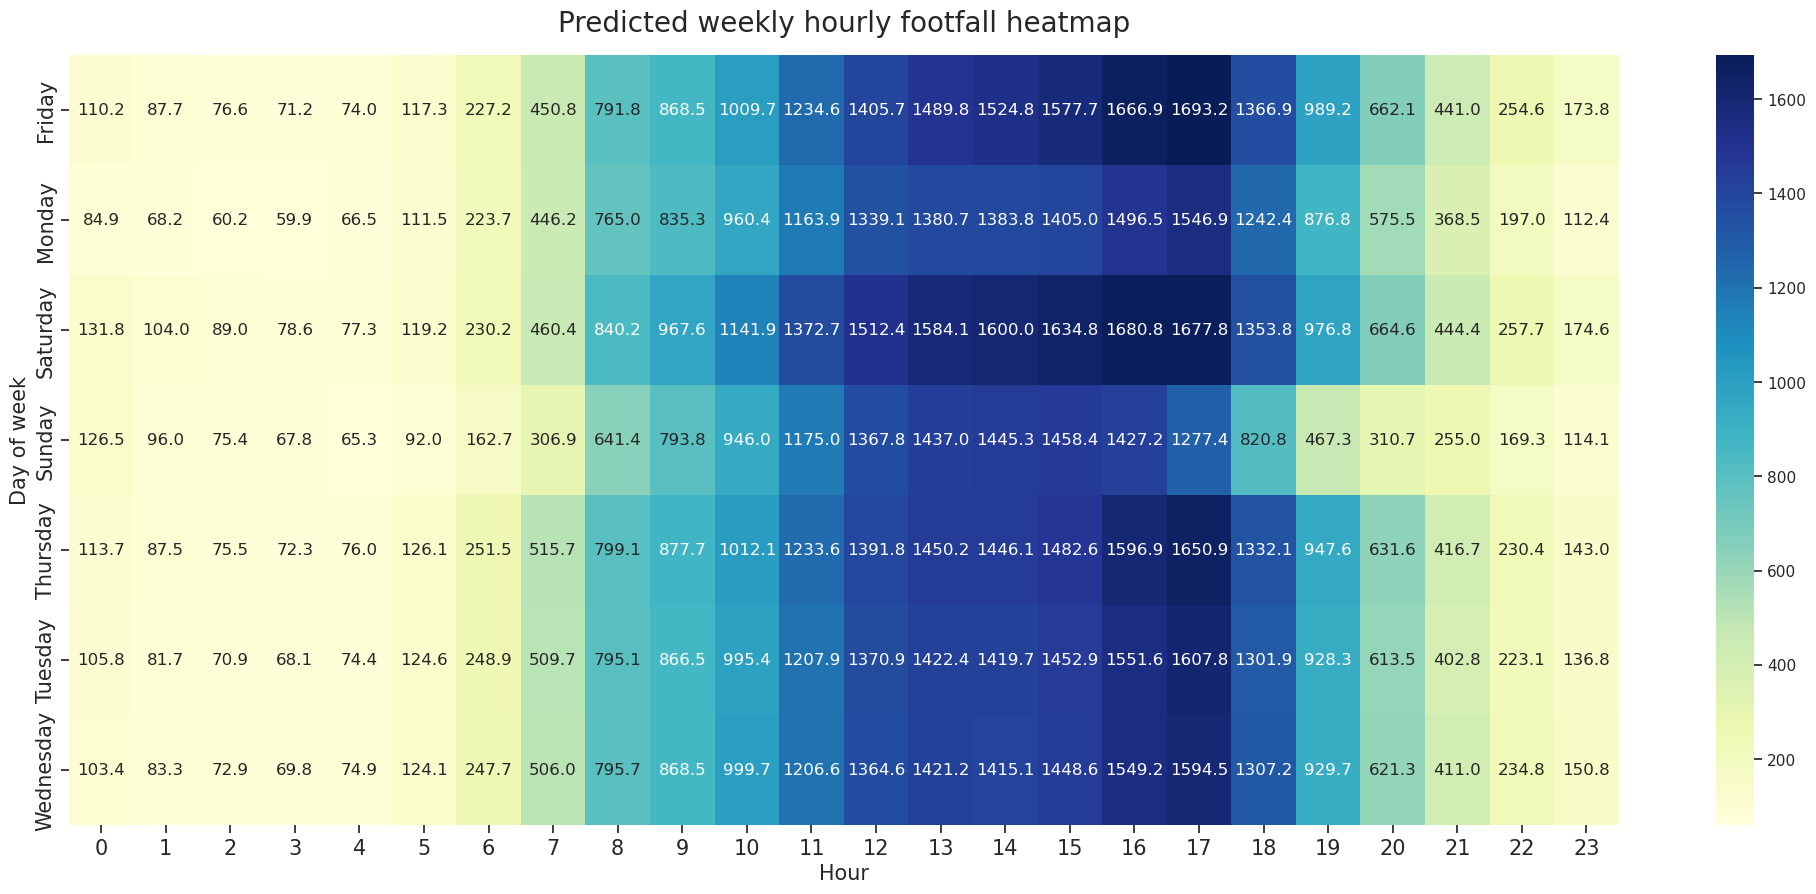

In [82]:
hourly_avg_pre = future_features_monthly_footfallweather_preds_results.groupby(['dayofweek', 'hour'])['predicted_footfall'].mean().unstack()

plt.figure(figsize=(25, 10))
sns.heatmap(hourly_avg_pre, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title('Predicted weekly hourly footfall heatmap', fontsize=20, y=1.02)
plt.xlabel('Hour', fontsize=15)
plt.ylabel('Day of week', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.savefig('../final_graph/weekly_hourly_heatmap_pre.png')
plt.show()

# footfall+tfl

In [83]:
footfall_tfl_features = ['month', 'day', 'hour', 'minute', 'is_holiday', 'after_day', 'is_sales',
    'dayofweek_Monday', 'dayofweek_Thursday',
    'dayofweek_Tuesday', 'dayofweek_Wednesday', 'season_Spring', 'season_Summer', 'season_Winter',
    'sub_MTT', 'sub_SAT', 'sub_SUN', 'Entry', 'Exit', 'footfall_previous']

X_train_final_filled_footfalltfl = X_train_final_filled[footfall_tfl_features]
X_test_final_filled_footfalltfl = X_test_final_filled[footfall_tfl_features]

In [84]:
# from sklearn.model_selection import GridSearchCV
# from xgboost import XGBRegressor

# param_grid = {
#     'n_estimators': [60, 70, 90, 100],
#     'max_depth': [3, 4, 5, 7],
#     'learning_rate': [0.04, 0.05, 0.08]
# }

# model = XGBRegressor()

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2', cv=5, verbose=1)
# grid_search.fit(X_train_final_filled_footfalltfl, y_train_filled_filled)

# print("Best parameters found: ", grid_search.best_params_)
# print("Best R²: ", grid_search.best_score_)


In [85]:
# param_grid_further = {
#     'min_child_weight': [0, 0.01],
#     'gamma': [0, 0.01]
# }

# model_further = XGBRegressor(
#     random_state=42,
#     objective='reg:squarederror',
#     learning_rate=0.05,
#     max_depth=4,
#     n_estimators=70
# )

# grid_search_further = GridSearchCV(estimator=model_further, param_grid=param_grid_further, scoring='r2', cv=5, verbose=1)
# grid_search_further.fit(X_train_final_filled_footfalltfl, y_train_filled_filled)

# print("Best parameters found for min_child_weight and gamma: ", grid_search_further.best_params_)
# print("Best R² for min_child_weight and gamma: ", grid_search_further.best_score_)

In [86]:
# param_grid_sub_col = {
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.9, 1.0, 1.2]
# }

# model_sub_col = XGBRegressor(
#     random_state=42,
#     objective='reg:squarederror',
#     learning_rate=0.05,
#     max_depth=4,
#     n_estimators=70,
#     gamma=0,
#     min_child_weight=0
# )

# grid_search_sub_col = GridSearchCV(estimator=model_sub_col, param_grid=param_grid_sub_col, scoring='r2', cv=5, verbose=1)
# grid_search_sub_col.fit(X_train_final_filled_footfalltfl, y_train_filled_filled)

# print("Best parameters found for subsample and colsample_bytree: ", grid_search_sub_col.best_params_)
# print("Best R² for subsample and colsample_bytree: ", grid_search_sub_col.best_score_)

In [87]:
# param_grid_reg = {
#     'reg_alpha': [0.03, 0.04, 0.05],
#     'reg_lambda': [7,8,10,12]
# }

# model_reg = XGBRegressor(
#     random_state=42,
#     objective='reg:squarederror',
#     learning_rate=0.05,
#     max_depth=4,
#     n_estimators=70,
#     gamma=0,
#     min_child_weight=0,
#     subsample=0.9,
#     colsample_bytree=1.0
# )

# grid_search_reg = GridSearchCV(estimator=model_reg, param_grid=param_grid_reg, scoring='r2', cv=5, verbose=1)
# grid_search_reg.fit(X_train_final_filled_footfalltfl, y_train_filled_filled)

# print("Best parameters found for reg_alpha and reg_lambda: ", grid_search_reg.best_params_)
# print("Best R² for reg_alpha and reg_lambda: ", grid_search_reg.best_score_)

In [88]:
best_xgb_footfalltfl = XGBRegressor(
    random_state=42,
    objective='reg:squarederror',
    learning_rate=0.05,
    max_depth=4,
    n_estimators=70,
    gamma=0,
    min_child_weight=0,
    subsample=0.9,
    colsample_bytree=1.0,
    reg_alpha=0.04,
    reg_lambda=8
)

best_xgb_footfalltfl.fit(X_train_final_filled_footfalltfl, y_train_filled_filled)

train_preds = best_xgb_footfalltfl.predict(X_train_final_filled_footfalltfl)
test_preds = best_xgb_footfalltfl.predict(X_test_final_filled_footfalltfl)

train_r2 = r2_score(y_train_filled_filled, train_preds)
test_r2 = r2_score(y_test_filled_filled, test_preds)
train_rmse = mean_squared_error(y_train_filled_filled, train_preds, squared=False)
test_rmse = mean_squared_error(y_test_filled_filled, test_preds, squared=False)

print("Final XGBoost model performance:")
print(f"Train R2: {train_r2}")
print(f"Test R2: {test_r2}")
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

/opt/conda/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/opt/conda/li

Final XGBoost model performance:
Train R2: 0.9537258542924201
Test R2: 0.9173096370475656
Train RMSE: 91.92232229755827
Test RMSE: 150.57214011117534


/opt/conda/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)


<Figure size 1000x1000 with 0 Axes>

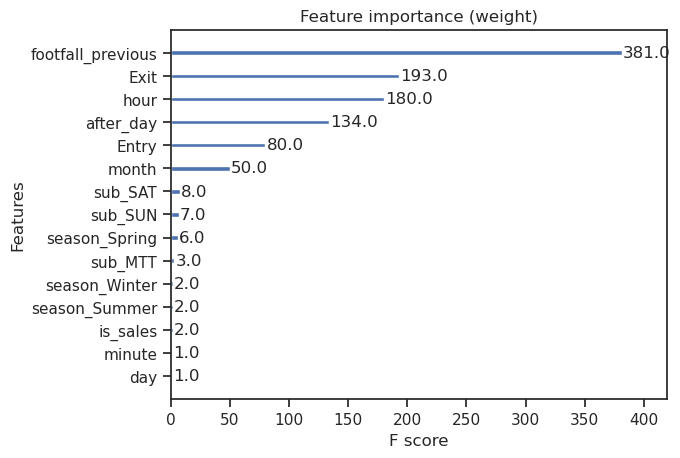

In [89]:
plt.figure(figsize=(10, 10))
plot_importance(best_xgb_footfalltfl, importance_type='weight', max_num_features=len(best_xgb_footfalltfl.get_booster().feature_names))
plt.title('Feature importance (weight)')
plt.grid(False)
#plt.savefig('../final_graph/importance_footfalltfl.png')
plt.show()

In [90]:
start_date = pd.to_datetime('2025-07-01')
start_timestamp = pd.to_datetime('2025-07-01 00:00:00')
future_dates_weekly_footfalltfl = create_future_dates(start_date, 7 * 24 * 12)
future_dates_monthly_footfalltfl = create_future_dates(start_date, 31 * 24 * 12)

future_features_weekly_footfalltfl = create_features(future_dates_weekly_footfalltfl, start_timestamp)
future_features_monthly_footfalltfl = create_features(future_dates_monthly_footfalltfl, start_timestamp)

future_features_weekly_footfalltfl.info(), future_features_monthly_footfalltfl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   month       2016 non-null   int32 
 1   day         2016 non-null   int32 
 2   hour        2016 non-null   int32 
 3   minute      2016 non-null   int32 
 4   is_holiday  2016 non-null   bool  
 5   after_day   2016 non-null   int64 
 6   dayofweek   2016 non-null   object
 7   season      2016 non-null   object
 8   sub         2016 non-null   object
 9   is_sales    2016 non-null   bool  
dtypes: bool(2), int32(4), int64(1), object(3)
memory usage: 98.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8928 entries, 0 to 8927
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   month       8928 non-null   int32 
 1   day         8928 non-null   int32 
 2   hour        8928 non-null   int32 
 3   minute      8928 non-null   int

(None, None)

In [91]:
tfl = pd.read_csv('expanded_tfl.csv')

data_2018 = tfl[tfl['Year'] == 2018]
data_2019 = tfl[tfl['Year'] == 2019]
total_entry_2018 = data_2018['Entry'].sum()
total_entry_2019 = data_2019['Entry'].sum()
total_exit_2018 = data_2018['Exit'].sum()
total_exit_2019 = data_2019['Exit'].sum()

growth_rate_entry = (1 + (total_entry_2019 - total_entry_2018) / total_entry_2018) #** 2
growth_rate_exit = (1 + (total_exit_2019 - total_exit_2018) / total_exit_2018) #** 2

growth_rate_entry, growth_rate_exit


(1.0303335942508107, 1.0629747331518717)

In [92]:
def add_tfl_features(future_features, tfl_data, growth_rate_entry, growth_rate_exit):
    tfl_features = []
    for i, row in future_features.iterrows():
        sub = row['sub']
        hour = row['hour']
        minute = row['minute']
        time = hour * 100 + minute 
        tfl_record = tfl_data.loc[(tfl_data['Match_day'] == sub) & (tfl_data['Time'] == time) & (tfl_data['Year'] == 2019)]
        if not tfl_record.empty:
            entry = tfl_record['Entry'].values[0] * 1 
            exit = tfl_record['Exit'].values[0] * 1 
            tfl_features.append([entry, exit])
        else:
            tfl_features.append([np.nan, np.nan])
    tfl_df = pd.DataFrame(tfl_features, columns=['Entry', 'Exit'])
    future_features = pd.concat([future_features.reset_index(drop=True), tfl_df], axis=1)
    return future_features


In [93]:
future_features_weekly_footfalltfl = add_tfl_features(future_features_weekly_footfalltfl, tfl, growth_rate_entry, growth_rate_exit)
future_features_monthly_footfalltfl = add_tfl_features(future_features_monthly_footfalltfl, tfl, growth_rate_entry, growth_rate_exit)
future_features_weekly_footfalltfl.info(), future_features_monthly_footfalltfl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   month       2016 non-null   int32  
 1   day         2016 non-null   int32  
 2   hour        2016 non-null   int32  
 3   minute      2016 non-null   int32  
 4   is_holiday  2016 non-null   bool   
 5   after_day   2016 non-null   int64  
 6   dayofweek   2016 non-null   object 
 7   season      2016 non-null   object 
 8   sub         2016 non-null   object 
 9   is_sales    2016 non-null   bool   
 10  Entry       2016 non-null   float64
 11  Exit        2016 non-null   float64
dtypes: bool(2), float64(2), int32(4), int64(1), object(3)
memory usage: 130.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8928 entries, 0 to 8927
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   month       8928 non-null   int32  
 1   d

(None, None)

In [94]:
future_features_weekly_footfalltfl = pd.get_dummies(future_features_weekly_footfalltfl, columns=['dayofweek', 'sub'], drop_first=True)
future_features_monthly_footfalltfl = pd.get_dummies(future_features_monthly_footfalltfl, columns=['dayofweek', 'sub'], drop_first=True)
future_features_weekly_footfalltfl = pd.get_dummies(future_features_weekly_footfalltfl, columns=['season'], drop_first=False)
future_features_monthly_footfalltfl = pd.get_dummies(future_features_monthly_footfalltfl, columns=['season'], drop_first=False)

season_columns = ['season_Spring', 'season_Winter']
for col in season_columns:
    if col not in future_features_weekly_footfalltfl.columns:
        future_features_weekly_footfalltfl[col] = False
    if col not in future_features_monthly_footfalltfl.columns:
        future_features_monthly_footfalltfl[col] = False
future_features_weekly_footfalltfl.info(), future_features_monthly_footfalltfl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   month                2016 non-null   int32  
 1   day                  2016 non-null   int32  
 2   hour                 2016 non-null   int32  
 3   minute               2016 non-null   int32  
 4   is_holiday           2016 non-null   bool   
 5   after_day            2016 non-null   int64  
 6   is_sales             2016 non-null   bool   
 7   Entry                2016 non-null   float64
 8   Exit                 2016 non-null   float64
 9   dayofweek_Monday     2016 non-null   bool   
 10  dayofweek_Saturday   2016 non-null   bool   
 11  dayofweek_Sunday     2016 non-null   bool   
 12  dayofweek_Thursday   2016 non-null   bool   
 13  dayofweek_Tuesday    2016 non-null   bool   
 14  dayofweek_Wednesday  2016 non-null   bool   
 15  sub_MTT              2016 non-null   b

(None, None)

In [95]:
future_features_weekly_footfalltfl = future_features_weekly_footfalltfl.drop(columns=['dayofweek_Saturday', 'dayofweek_Sunday'])
future_features_monthly_footfalltfl = future_features_monthly_footfalltfl.drop(columns=['dayofweek_Saturday', 'dayofweek_Sunday'])

In [96]:
future_features_weekly_footfalltfl['footfall_previous'] = np.nan
future_features_monthly_footfalltfl['footfall_previous'] = np.nan
def predict_footfalltfl(future_features, feature_columns):
    predicted_footfall = []
    for i in range(len(future_features)):
        if i >= 12: 
            future_features.loc[i, 'footfall_previous'] = predicted_footfall[-12]
        current_features = future_features[feature_columns].iloc[i].values.reshape(1, -1)
        current_footfall = best_xgb_footfalltfl.predict(current_features)[0]
        predicted_footfall.append(current_footfall)
    return predicted_footfall

future_features_weekly_footfalltfl_preds_results = predict_footfalltfl(future_features_weekly_footfalltfl, footfall_tfl_features)
future_features_monthly_footfalltfl_preds_results = predict_footfalltfl(future_features_monthly_footfalltfl, footfall_tfl_features)


In [97]:
future_features_weekly_footfalltfl = future_features_weekly_footfalltfl.reindex(columns=X_train_final_filled_footfalltfl.columns, fill_value=0)
future_features_monthly_footfalltfl = future_features_monthly_footfalltfl.reindex(columns=X_train_final_filled_footfalltfl.columns, fill_value=0)

future_features_weekly_footfalltfl_preds = best_xgb_footfalltfl.predict(future_features_weekly_footfalltfl)
future_features_monthly_footfalltfl_preds = best_xgb_footfalltfl.predict(future_features_monthly_footfalltfl)


/opt/conda/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/opt/conda/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or is_categorical_dtype(dtype)
/opt/conda/li

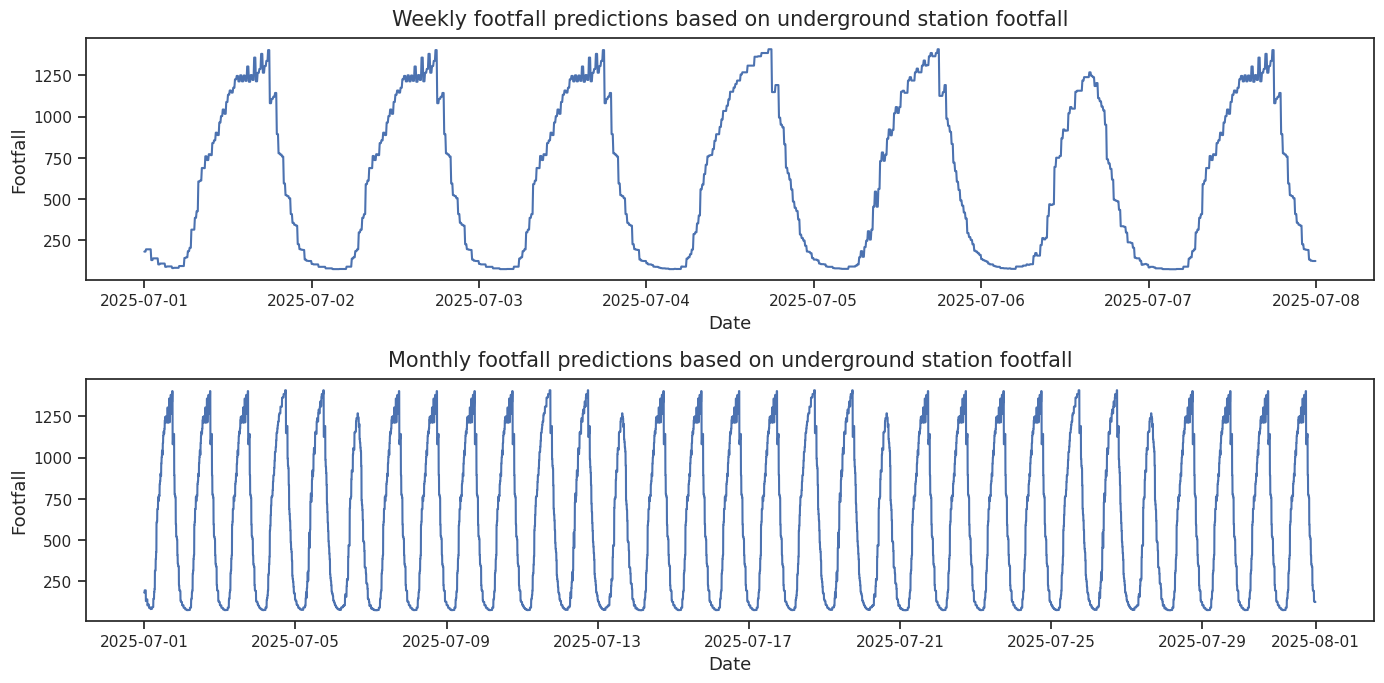

In [98]:
future_features_weekly_footfalltfl_preds_results = pd.DataFrame({'timestamp': future_dates_weekly_footfalltfl, 'predicted_footfall': future_features_weekly_footfalltfl_preds})
future_features_monthly_footfalltfl_preds_results = pd.DataFrame({'timestamp': future_dates_monthly_footfalltfl, 'predicted_footfall': future_features_monthly_footfalltfl_preds})


plt.figure(figsize=(14, 7))


plt.subplot(2, 1, 1)
plt.plot(future_features_weekly_footfalltfl_preds_results['timestamp'], future_features_weekly_footfalltfl_preds_results['predicted_footfall'], label='Weekly Predicted Footfall')
plt.title('Weekly footfall predictions based on underground station footfall', fontsize=15,y=1.02)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Footfall', fontsize=13)


plt.subplot(2, 1, 2)
plt.plot(future_features_monthly_footfalltfl_preds_results['timestamp'], future_features_monthly_footfalltfl_preds_results['predicted_footfall'], label='Monthly Predicted Footfall')
plt.title('Monthly footfall predictions based on underground station footfall', fontsize=15,y=1.02)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Footfall', fontsize=13)

plt.tight_layout()
#plt.savefig('../final_graph/footfalltfl_preds.png')
plt.show()

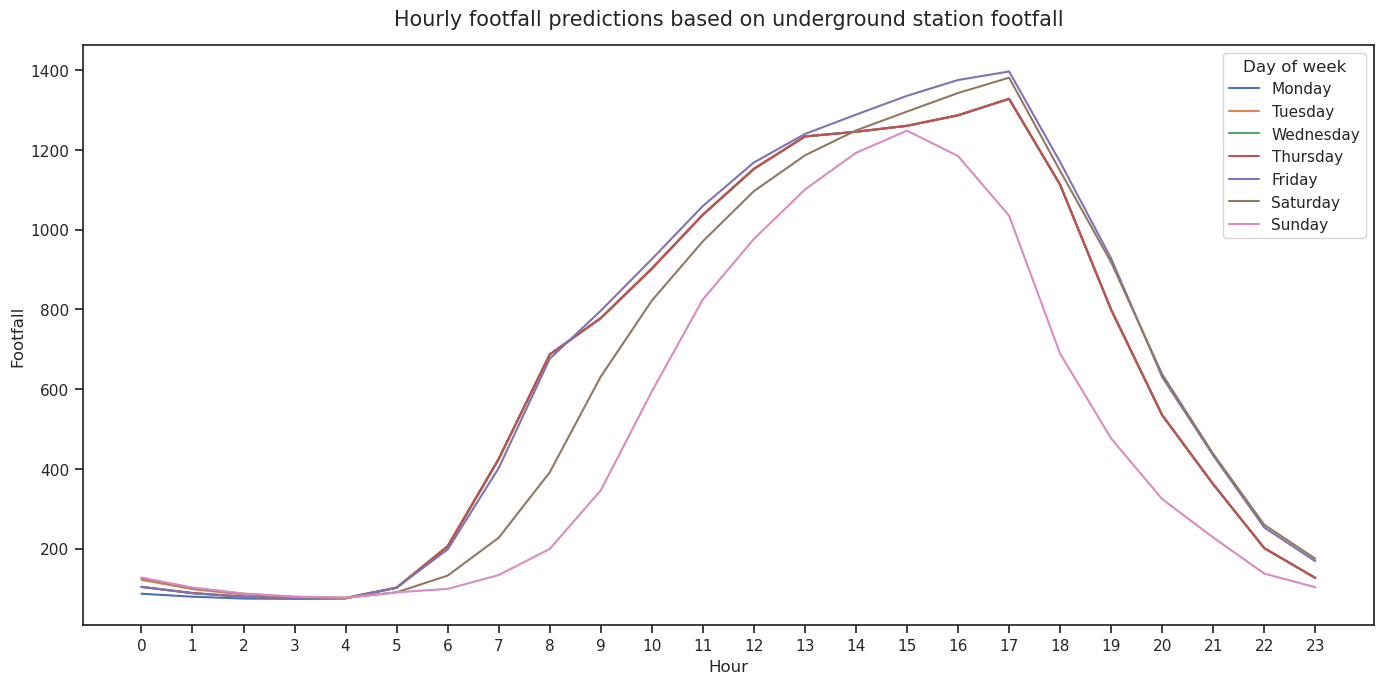

In [99]:
future_features_monthly_footfalltfl_preds_results['dayofweek'] = future_features_monthly_footfalltfl_preds_results['timestamp'].dt.day_name()
future_features_monthly_footfalltfl_preds_results['hour'] = future_features_monthly_footfalltfl_preds_results['timestamp'].dt.hour

average_footfall = future_features_monthly_footfalltfl_preds_results.groupby(['dayofweek', 'hour'])['predicted_footfall'].mean().reset_index()

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_footfall['dayofweek'] = pd.Categorical(average_footfall['dayofweek'], categories=days_order, ordered=True)
average_footfall = average_footfall.sort_values(['dayofweek', 'hour'])

plt.figure(figsize=(14, 7))

for day in days_order:
    daily_data = average_footfall[average_footfall['dayofweek'] == day]
    plt.plot(daily_data['hour'], daily_data['predicted_footfall'], label=day)

plt.title('Hourly footfall predictions based on underground station footfall', fontsize=15,y=1.02)
plt.xlabel('Hour')
plt.ylabel('Footfall')
plt.xticks(range(0, 24, 1))
plt.legend(title='Day of week')
plt.tight_layout()
#plt.savefig('../final_graph/average_footfalltfl_preds_by_hour_weekly.png')
plt.show()